## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data

import numpy as np
import torch
from torch.optim import Adam, SGD
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import time
from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# The last two columns are the target variables (Heating Load and Cooling Load)
X = data.iloc[:, :-2].values  # Covariates
y = data.iloc[:, -2].values  # Heating Load
dataset = 'energy'

In [5]:
# # Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# # URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# # Load the dataset directly into a Pandas DataFrame
# data = pd.read_csv(url, delimiter=";")

# X = data.iloc[:, :-1].values
# y = data.iloc[:, -1].values

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized] 

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

## Case 1: Analytical attack - Max disruption

In [7]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [8]:
def kl_div(mu_n, lam_n, sigma2, x, x_adv):
    sigma2_A = x_adv.T @ torch.inverse(lam_n) @ x_adv + sigma2
    mu_A = x_adv.T @ mu_n
    sigma2_D = x.T @ torch.inverse(lam_n) @ x + sigma2
    mu_D = x.T @ mu_n
    kl = 0.5 * (torch.log(sigma2_A / sigma2_D) + (sigma2_D + (mu_D - mu_A)**2) / sigma2_A - 1)
    return kl

In [9]:
# kl maximization to find adversarial attacked to a trained model
def kl_maximization(model, x, lr=0.01, n_iter=100, epsilon=.3):
    x_adv_values = []
    kl_values = []
    
    mu_n = model.mu
    lam_n = model.lam
    sigma2 = model.sigma2
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
        kl.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        kl_values.append(-kl.detach().item())

    return x_adv.detach(), x_adv_values, kl_values 

In [10]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values, kl_values = kl_maximization(model, x, epsilon=0.3)

Text(0, 0.5, 'KL Divergence')

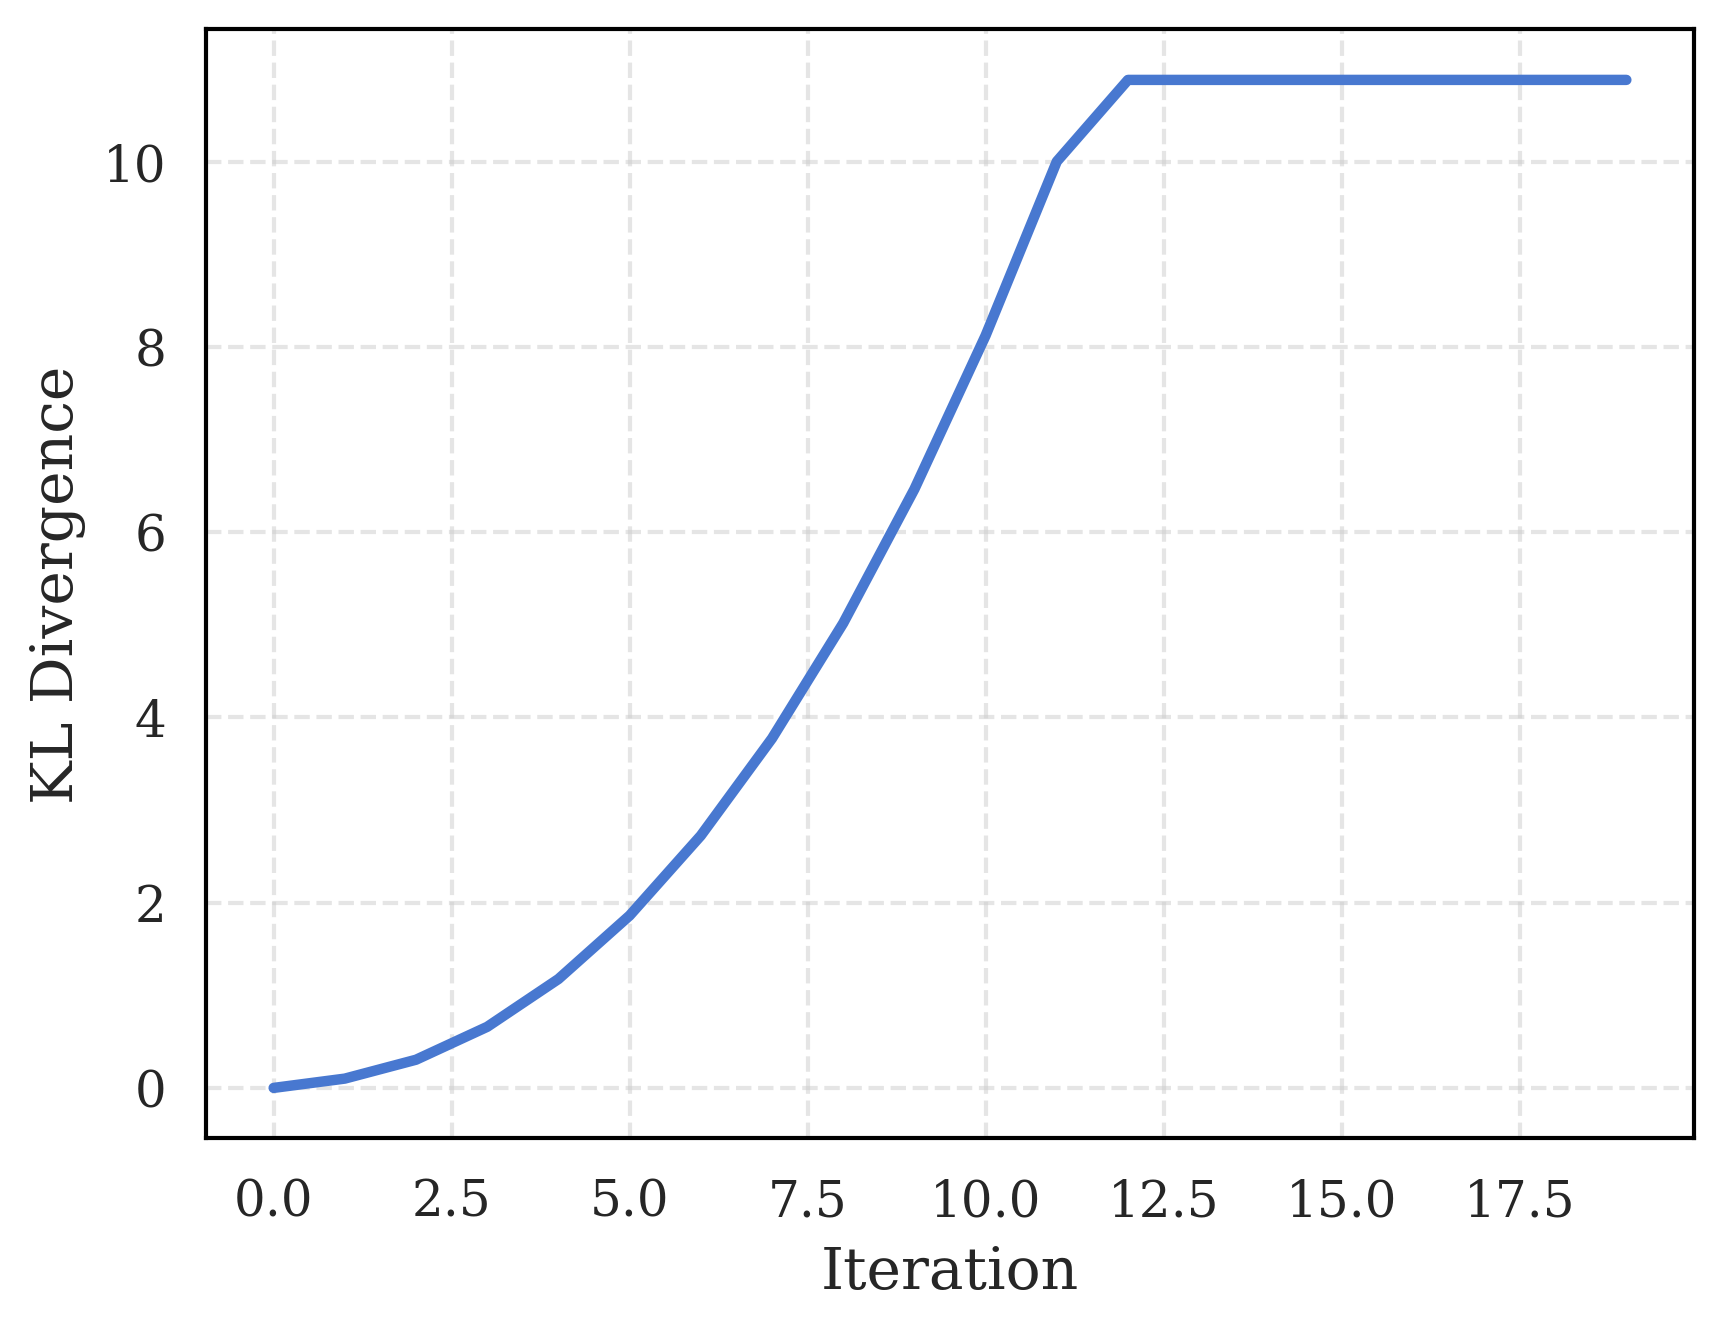

In [11]:
plt.plot(kl_values[:20])
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

Text(0.5, 0, 'y')

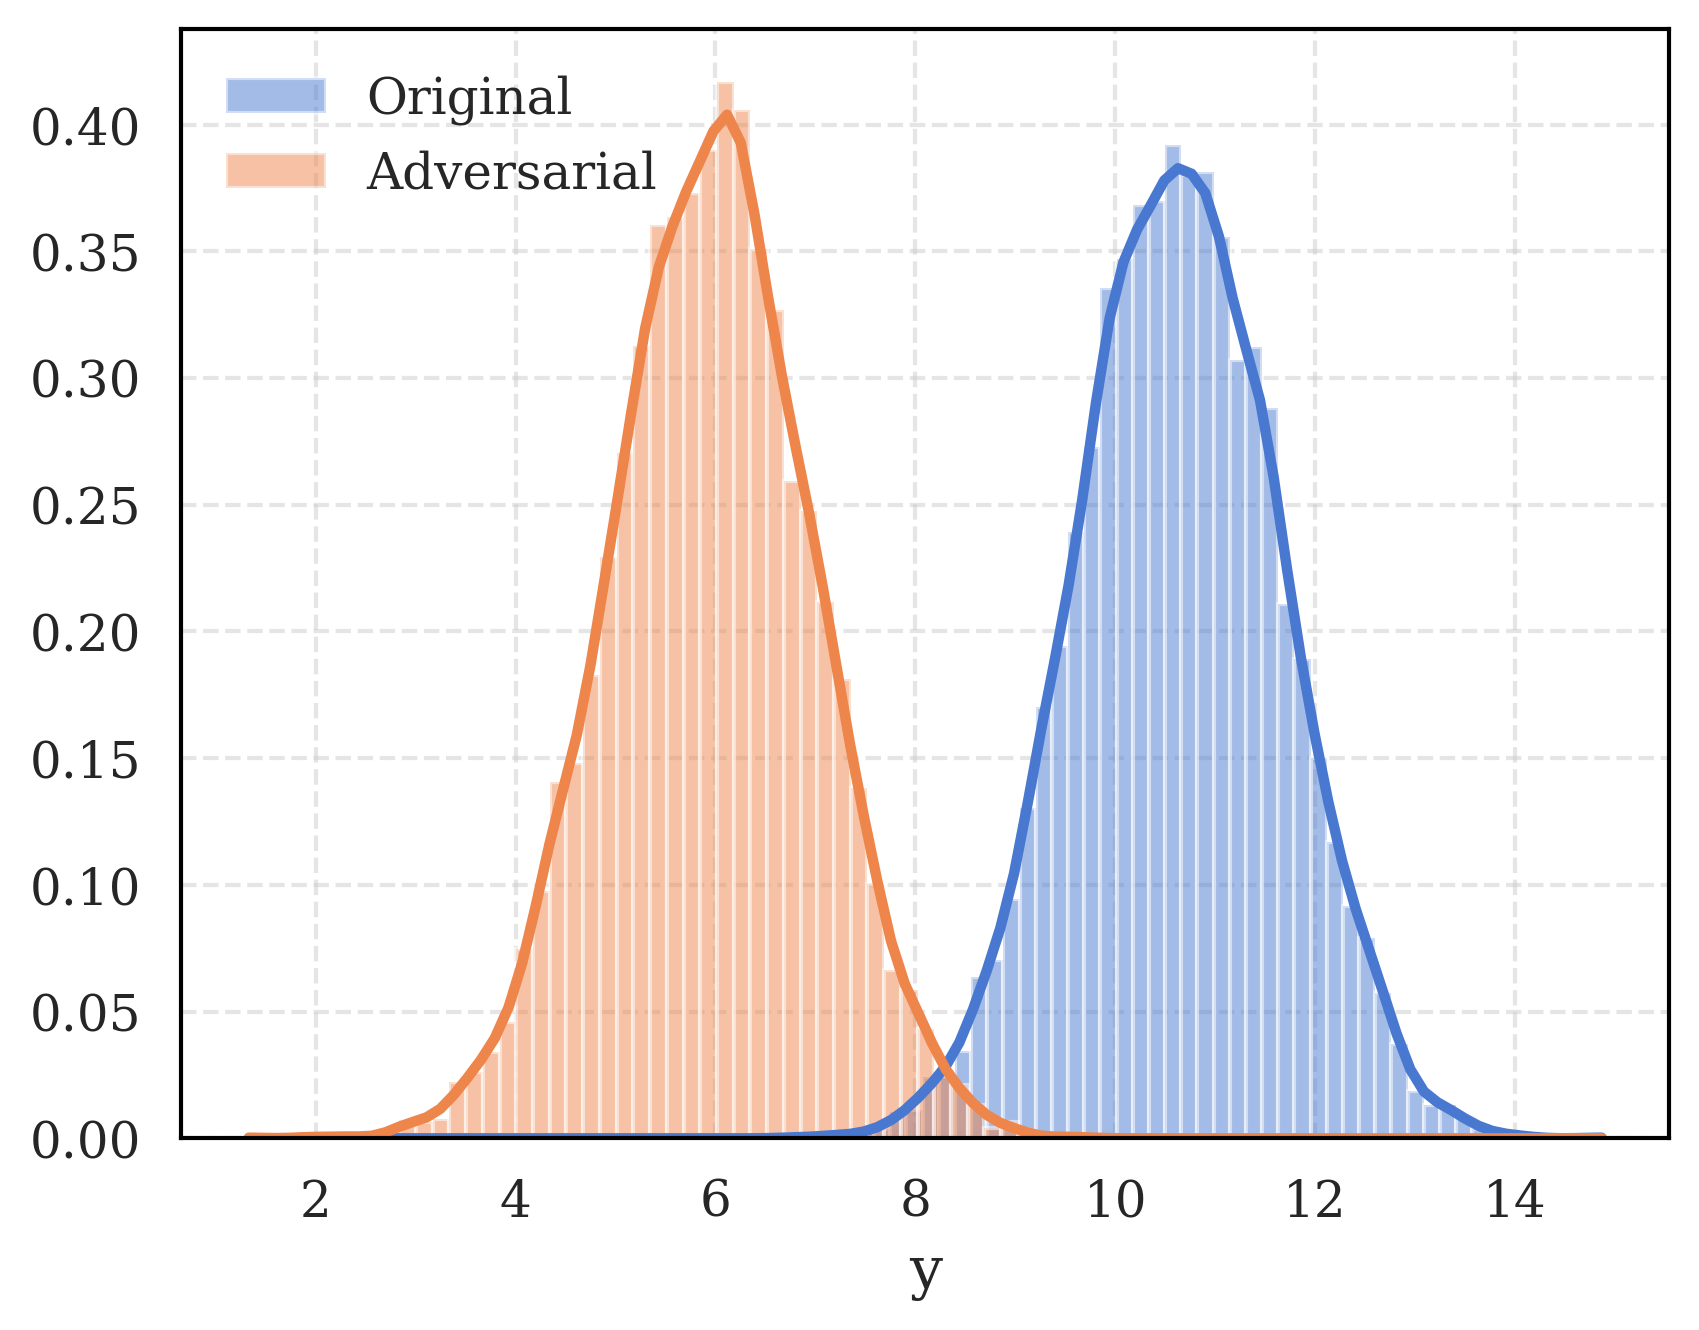

In [12]:
y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()

kde = gaussian_kde(y_samples.T)
kde_adv = gaussian_kde(y_adv_samples.T)

plt.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

ys = np.linspace(
    min(np.min(y_samples), np.min(y_adv_samples)), 
    max(np.max(y_samples), np.max(y_adv_samples)), 
    100)
# plot with same color and label
plt.plot(ys, kde(ys), color='C0')
plt.plot(ys, kde_adv(ys), color='C1')
plt.legend()
plt.xlabel('y')

Text(0, 0.5, 'KL Divergence')

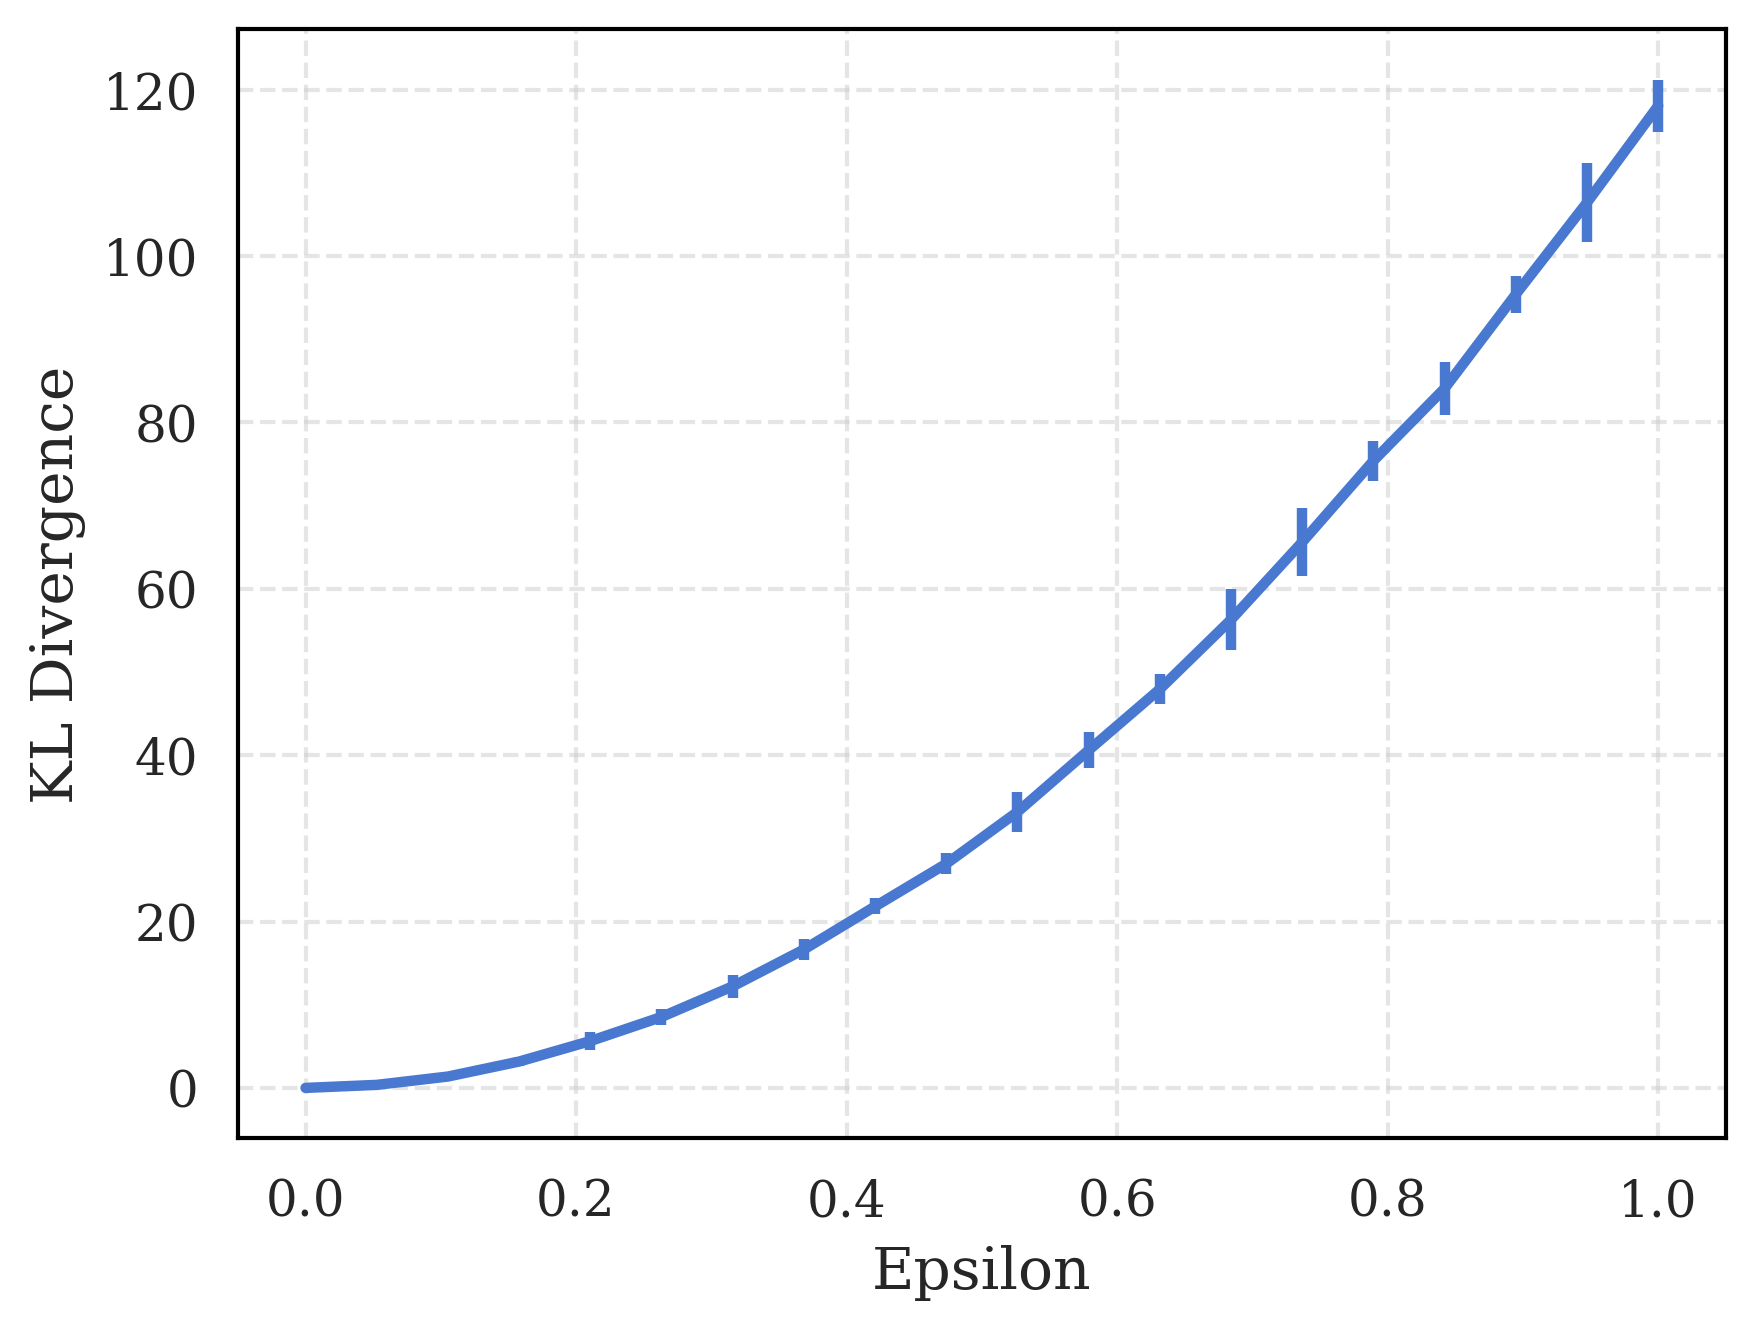

In [13]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

kl_alls = []
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    kl_values = []
    for epsilon in epsilons:
        x_adv_distr, _, kl = kl_maximization(model, x, epsilon=epsilon)
        kl_values.append(kl[-1])
    kl_alls.append(kl_values)

# std as error bars
plt.errorbar(epsilons, np.mean(kl_alls, axis=0), yerr=2*np.std(kl_alls, axis=0))
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

## Case 2: SGD attack

### Attack definition

In [14]:
# Function pi(y | x, gamma)
def pi(y, x, gamma):
    return torch.distributions.normal.Normal(x.T @ gamma[0], gamma[1]).log_prob(y).exp()

# Gradient of pi(y | x, gamma) with respect to x
# pi(y | x, gamma) is Normal(x.T @ beta, sigma2) with beta = gamma[0] and sigma2 = gamma[1]
def grad_pi(y, x, gamma): 
    distr = torch.distributions.normal.Normal(x.T @ gamma[0], gamma[1])
    prob = distr.log_prob(y).exp()
    grad = (y - x.T @ gamma[0]) / gamma[1] * prob * gamma[0]
    return grad


In [15]:
# g_{x, M}(y)
def g_x_M(y, x, gamma_samples): 
    # betas and sigmas shape: (D, M) and (1, M)
    grad_pi_vals = grad_pi(y, x, gamma_samples) 
    pi_vals = pi(y, x, gamma_samples) 
    numerator = torch.mean(grad_pi_vals, dim=1, keepdim=True)  # Promedio sobre M (segunda dimensión)
    denominator = torch.mean(pi_vals, dim=1)  # Promedio sobre M (segunda dimensión)
    return numerator / denominator  # not - since max disruption problem

In [16]:
# Compute Δg_{x, l}(y)
def delta_g_x_l(y, x, l, model, M_sequence):
    M_l = M_sequence[l]
    M_l_minus_1 = M_sequence[l-1] if l > 0 else 0
    gamma_samples_l = model.sample_posterior_distribution(M_l)
    
    # using the same samples for both terms in the difference
    gamma_samples_l_minus_1_a = [gamma_samples_l[0][:, :M_l_minus_1], gamma_samples_l[1][:, :M_l_minus_1]]
    gamma_samples_l_minus_1_b = [gamma_samples_l[0][:, M_l_minus_1:], gamma_samples_l[1][:, M_l_minus_1:]]

    g_l = g_x_M(y, x, gamma_samples_l)
    g_l_minus_1_a = g_x_M(y, x, gamma_samples_l_minus_1_a) if l > 0 else 0
    g_l_minus_1_b = g_x_M(y, x, gamma_samples_l_minus_1_b) if l > 0 else 0
    return g_l - (g_l_minus_1_a + g_l_minus_1_b) / 2

In [17]:
# Estimate the gradient using MLMC in parallel with joblib
def mlmc_gradient_estimator(y, x, R, model, M0=1, tau=1., n_jobs=50):
    # Define sequence M_l
    M_sequence = [M0*2**l for l in range(100)]

    # Define weights ω_l
    omega = [2**(-tau * l) for l in range(len(M_sequence))]
    omega = np.array(omega)
    omega /= omega.sum()  # Normalize

    l_indices = np.random.choice(len(M_sequence), size=R, p=omega)
    
    estimates = Parallel(n_jobs=n_jobs)(
        delayed(delta_g_x_l)(y, x, l, model, M_sequence) for l in l_indices
    )  
    estimates = [est / omega[l] for l, est in zip(l_indices, estimates)]
    return sum(estimates) / R

In [18]:
# Attack function to use the gradient estimator for maximum disruption
def mlmc_attack(model, x, appd=None, lr=0.01, n_iter=100, epsilon=.1, R=100, early_stopping_patience=10):
    """
    Function to perform the attack using the MLMC gradient estimator.
    :param appd: Attacker predictive posterior distribution to approximate. If None -> Maximum disruption attack.
    """
    x_adv_values = []
    patience = 0
    # x_adv = (x + torch.randn_like(x) * 0.01).clone().requires_grad_(True)  # add some noise to the input so kl is not zero
    x_adv = x.clone().requires_grad_(True)
    optimizer = SGD([x_adv], lr=lr)

    for it in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        if appd is None:
            y = model.sample_predictive_distribution(x, num_samples=1)
        else:
            y = appd.sample()
        start = time.time()
        if appd is None:
            x_adv.grad = mlmc_gradient_estimator(y, x_adv, R, model)
        else:
            x_adv.grad = - mlmc_gradient_estimator(y, x_adv, R, model)  # If appd is not None, we want to minimize the loss
        if time.time() - start > 2:
            print(f'Long gradient estimation time: {time.time() - start} for iteration {it}')
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())

        if it > 2 and np.linalg.norm(x_adv_values[-1] - x_adv_values[-2]) < 1e-3:
            patience += 1
            if patience >= early_stopping_patience:
                print(f'Early stopping at iteration {it}')
                break
        else:
            patience = 0

    return x_adv.detach(), x_adv_values

### Case 2a: NormalInverseGamma model

In [19]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([10]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


In [20]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=100, lr=0.01, n_iter=200)

Long gradient estimation time: 5.009270668029785 for iteration 0
Long gradient estimation time: 2.614828109741211 for iteration 156


Text(0.5, 0, 'y')

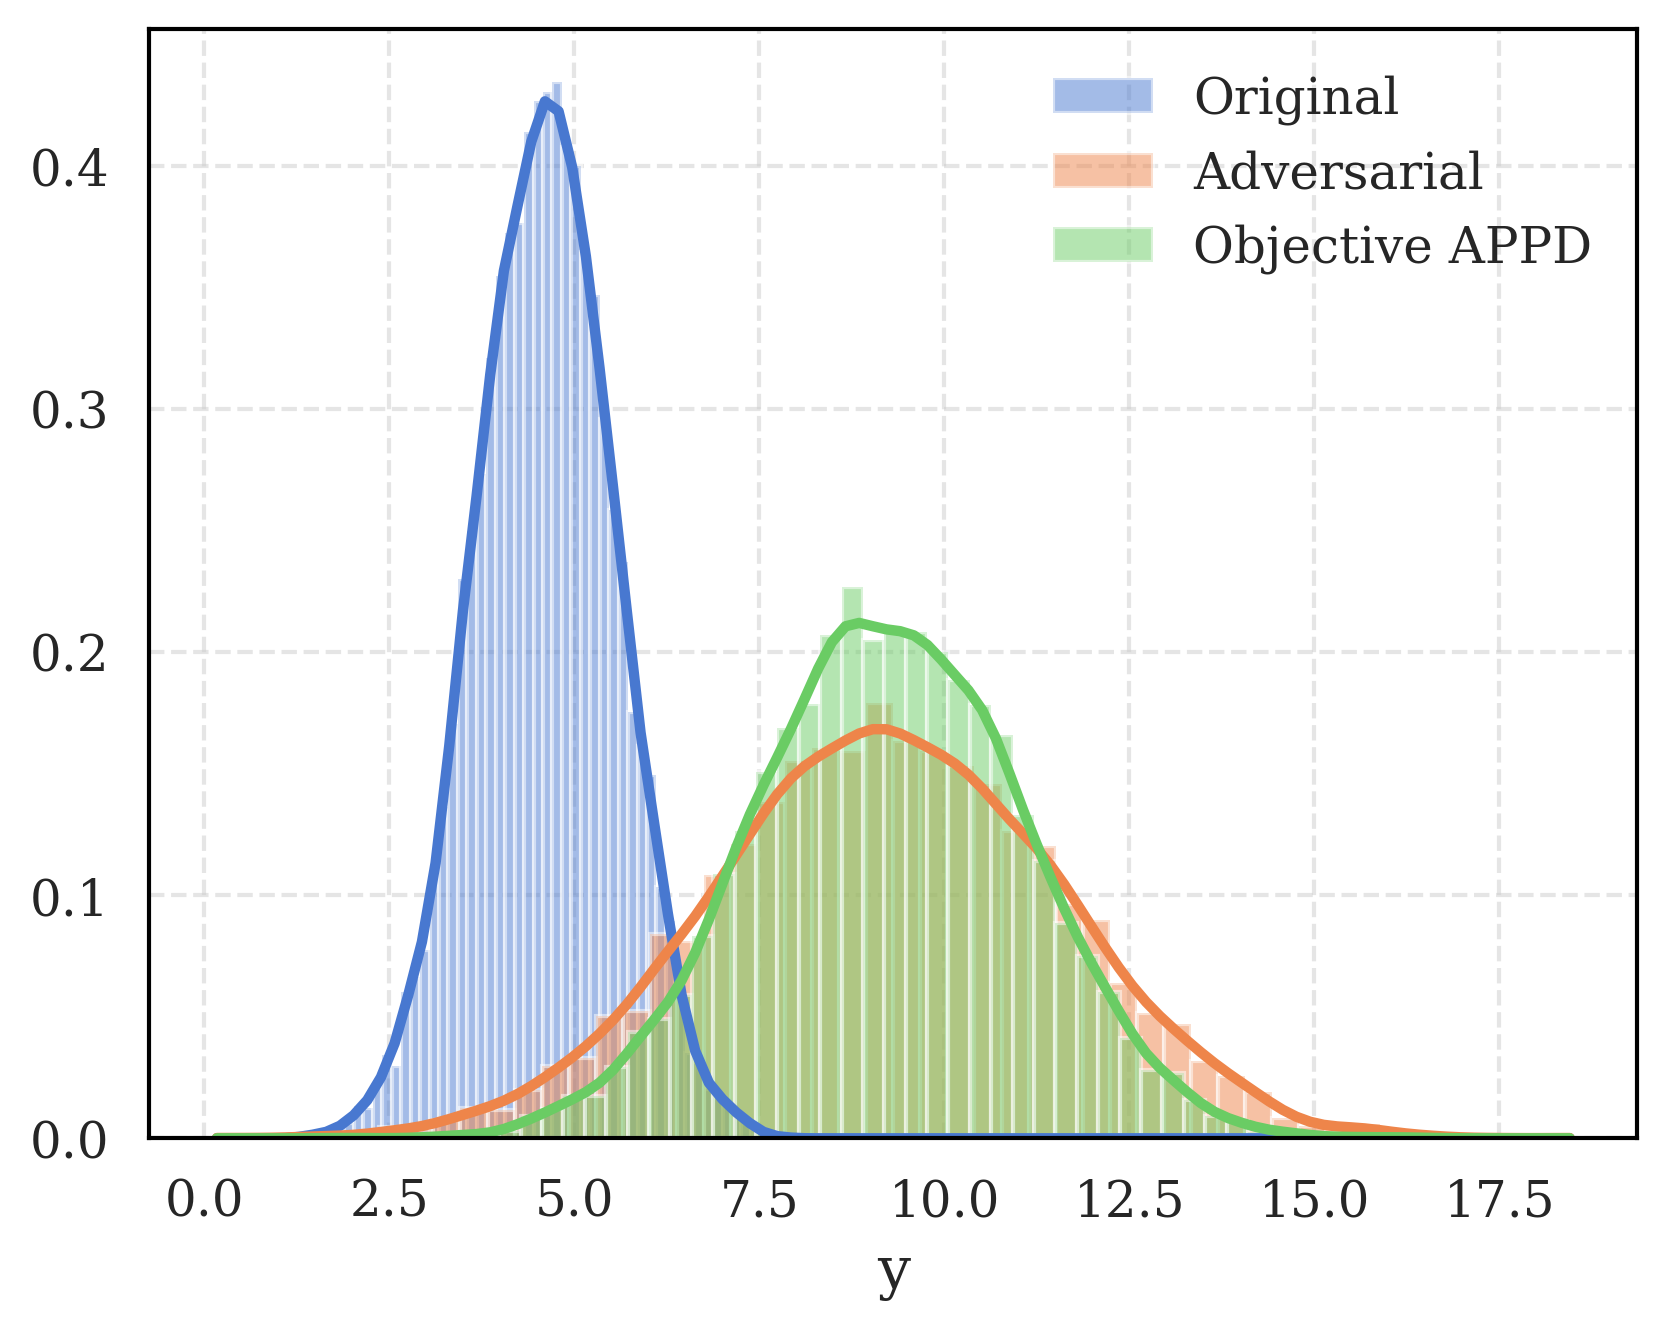

In [21]:
y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()
y_appd_samples = appd.sample((10000,)).numpy()

kde = gaussian_kde(y_samples.T)
kde_adv = gaussian_kde(y_adv_samples.T)
kde_appd = gaussian_kde(y_appd_samples.T)

plt.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)
plt.hist(y_appd_samples, bins=50, alpha=0.5, label='Objective APPD', density=True)

ys = np.linspace(
    min(np.min(y_samples), np.min(y_adv_samples), np.min(y_appd_samples)), 
    max(np.max(y_samples), np.max(y_adv_samples), np.max(y_appd_samples)), 
    100)
# plot with same color and label
plt.plot(ys, kde(ys), color='C0')
plt.plot(ys, kde_adv(ys), color='C1')
plt.plot(ys, kde_appd(ys), color='C2')
plt.legend()
plt.xlabel('y')


0
Long gradient estimation time: 3.631404399871826 for iteration 10
Early stopping at iteration 12
1
Early stopping at iteration 14
2
Early stopping at iteration 12
3
Early stopping at iteration 15
4
Early stopping at iteration 16
5
Early stopping at iteration 16
6
Early stopping at iteration 18
7
Early stopping at iteration 13
8
Early stopping at iteration 14
9
Early stopping at iteration 14


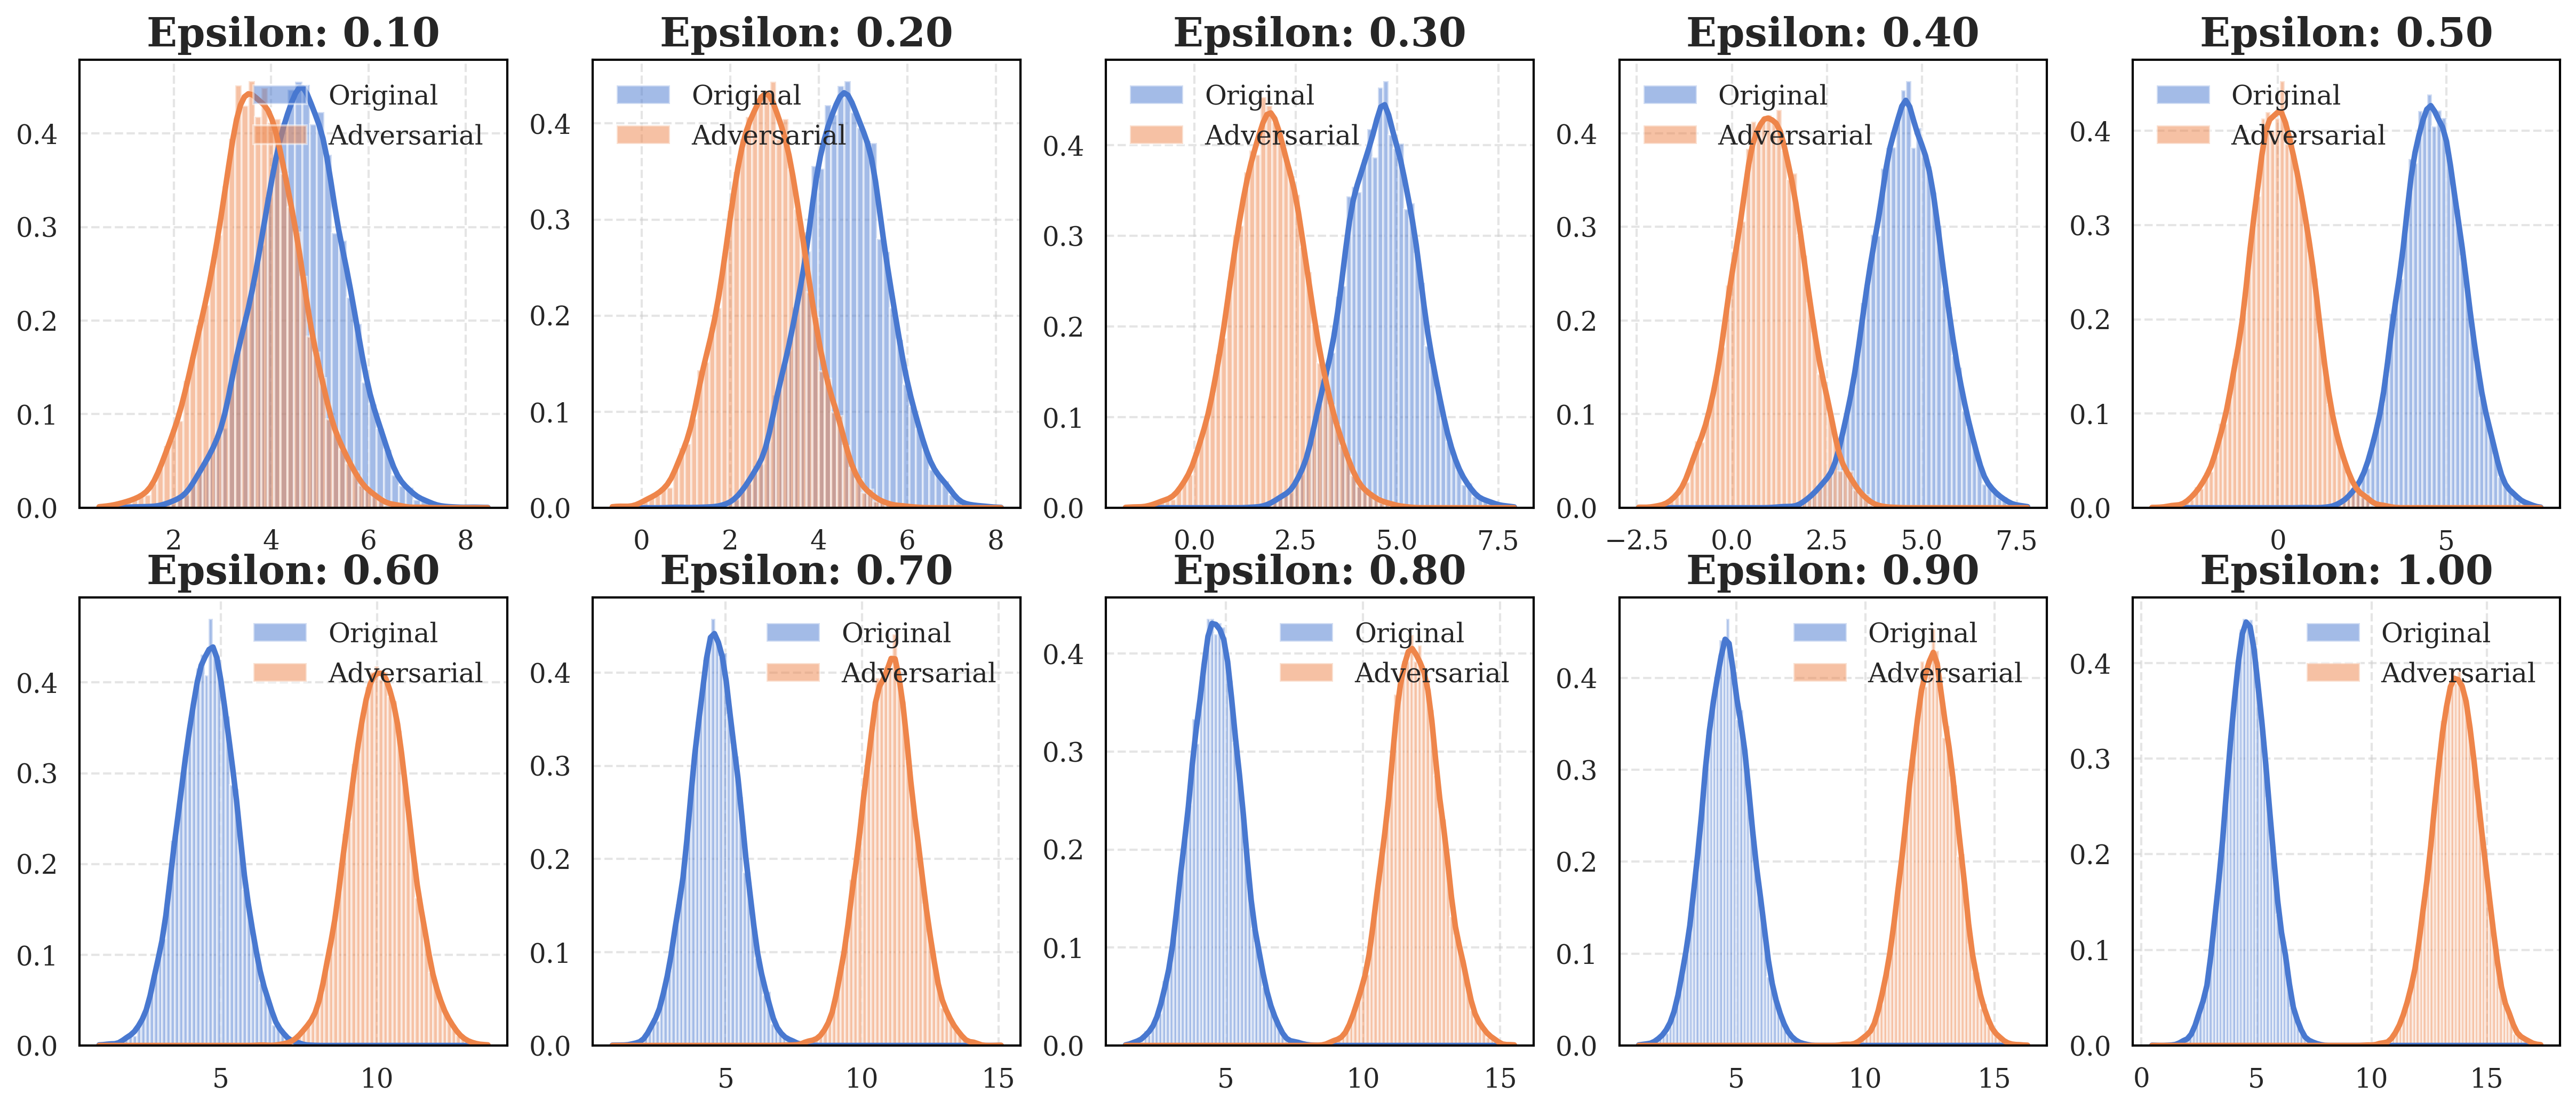

In [22]:
# Plot the histogram for 10 different epsilon values as subplots
epsilons = np.linspace(0.1, 1, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, epsilon in enumerate(epsilons):
    print(i)
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon)
    ax = axs[i // 5, i % 5]

    y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
    y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()

    kde = gaussian_kde(y_samples.T)
    kde_adv = gaussian_kde(y_adv_samples.T)

    ax.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
    ax.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

    ys = np.linspace(
        min(np.min(y_samples), np.min(y_adv_samples)), 
        max(np.max(y_samples), np.max(y_adv_samples)), 
        100)
    # plot with same color and label
    ax.plot(ys, kde(ys), color='C0')
    ax.plot(ys, kde_adv(ys), color='C1')
    ax.legend()

    ax.set_title(f'Epsilon: {epsilon:.2f}')

/tmp/ipykernel_4088304/1901980804.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)


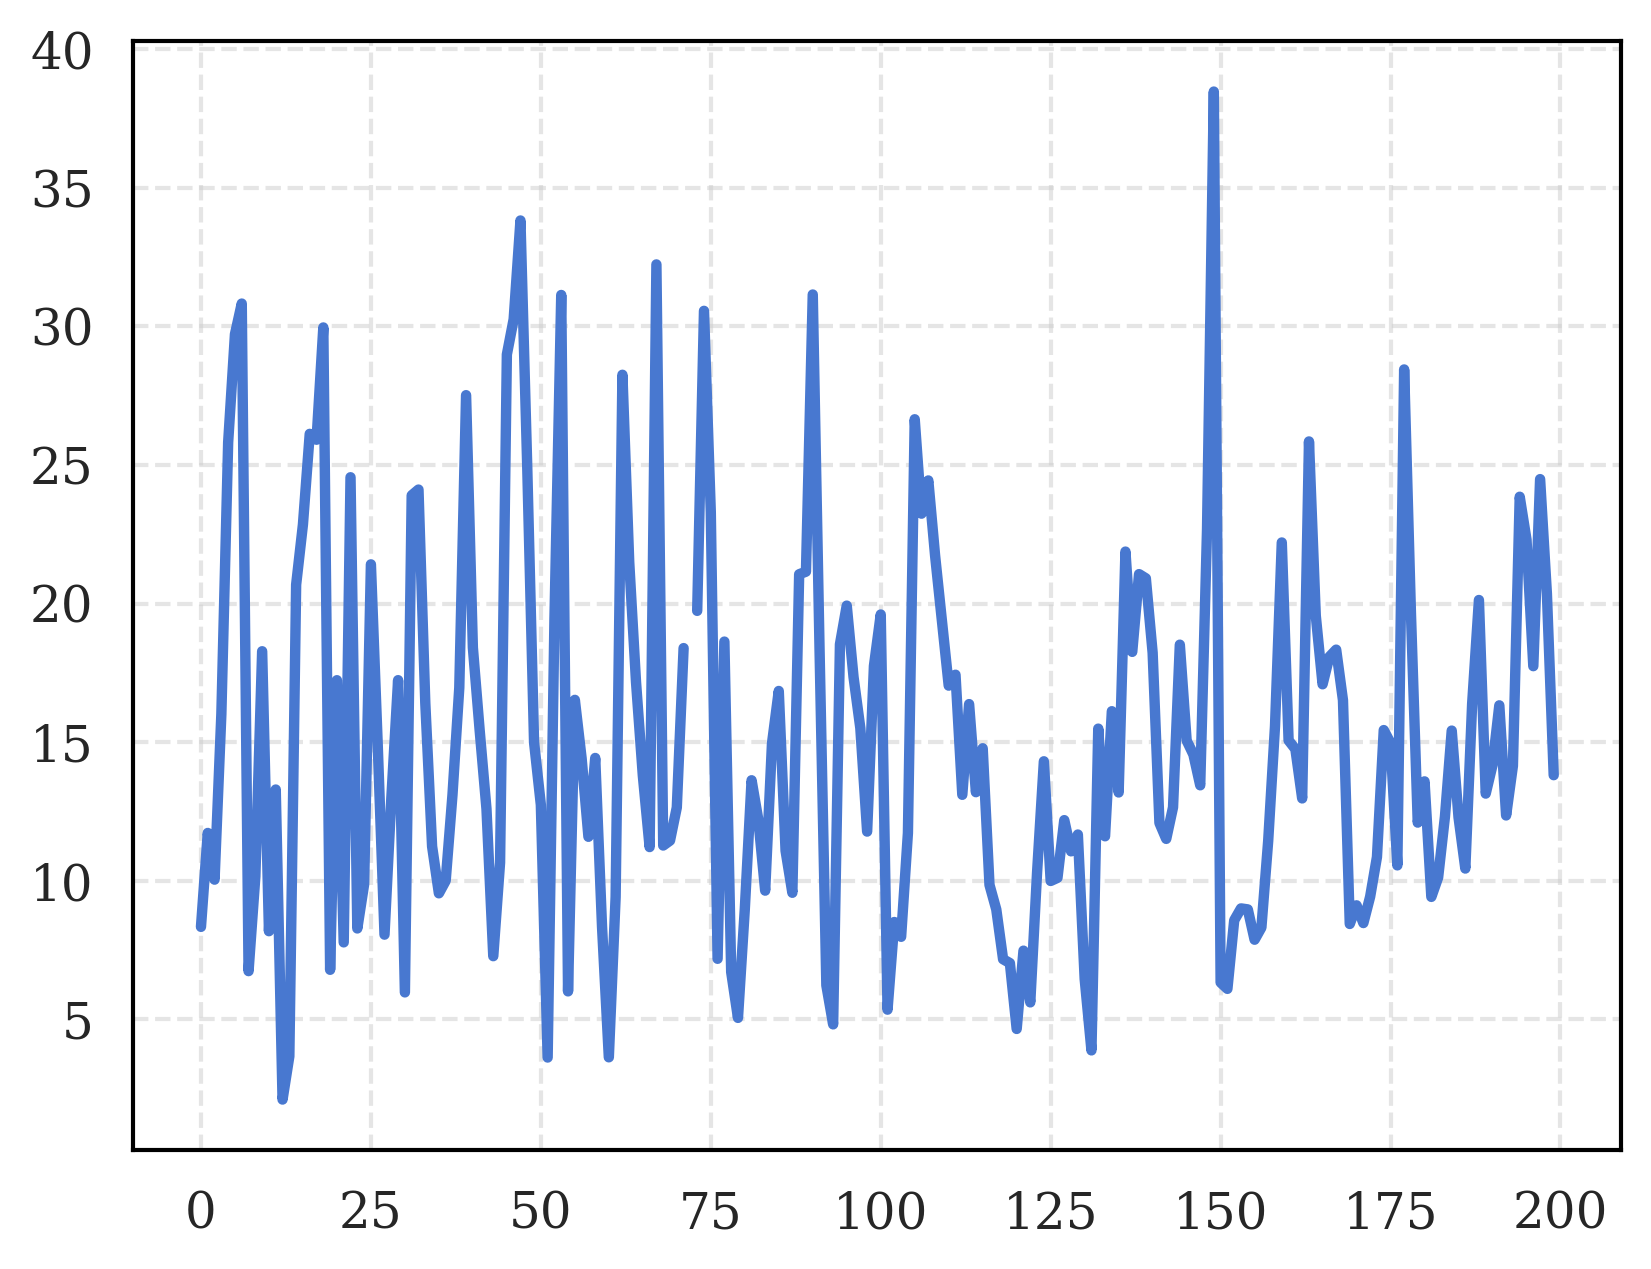

In [23]:
# Plot values evolution for the adversarial attack
kl_proxies = []
for x_adv in x_adv_values:
    y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)
    val = -torch.mean(torch.log(pi(y_samples, torch.tensor(x_adv, dtype=torch.float32), model.sample_posterior_distribution(100))))
    kl_proxies.append(val.item())

plt.plot(kl_proxies)

Long gradient estimation time: 2.070706605911255 for iteration 0
Long gradient estimation time: 3.4729998111724854 for iteration 1
Long gradient estimation time: 2.899915933609009 for iteration 3
Long gradient estimation time: 4.650030851364136 for iteration 1
Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 9.303560256958008 for iteration 1
Early stopping at iteration 14
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Long gradient estimation time: 4.347528696060181 for iteration 10
Long gradient estimation time: 4.227379560470581 for iteration 13
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 6.0490193367004395 for iteration 11
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 10.123229026794434 for iteration 5
Early stopping at iteration 17


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.01796293258667 for iteration 12
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.8310461044311523 for iteration 0
Long gradient estimation time: 2.761798858642578 for iteration 1
Long gradient estimation time: 2.218370199203491 for iteration 2
Long gradient estimation time: 2.6037309169769287 for iteration 1
Long gradient estimation time: 2.9735591411590576 for iteration 3
Early stopping at iteration 13
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 16
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.2425777912139893 for iteration 16
Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 17
Early stopping at iteration 13
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 16.54973578453064 for iteration 1
Long gradient estimation time: 2.094430446624756 for iteration 5
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 4.7370994091033936 for iteration 6
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 3.3658065795898438 for iteration 10
Early stopping at iteration 14
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 3.5818886756896973 for iteration 13
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 15.345921277999878 for iteration 7
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 54.2446026802063 for iteration 6
Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 5.044259786605835 for iteration 4
Long gradient estimation time: 2.434128999710083 for iteration 9
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 17
Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 17
Early stopping at iteration 17


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 8.294885635375977 for iteration 7
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 194.4408757686615 for iteration 12
Early stopping at iteration 17


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.1514225006103516 for iteration 2
Long gradient estimation time: 4.610097646713257 for iteration 2
Long gradient estimation time: 3.135767698287964 for iteration 6
Long gradient estimation time: 2.8375232219696045 for iteration 6
Long gradient estimation time: 2.955000877380371 for iteration 5
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Long gradient estimation time: 8.863597393035889 for iteration 1


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Long gradient estimation time: 2.7947001457214355 for iteration 7


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 15
Long gradient estimation time: 4.6811747550964355 for iteration 9


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 4.5069074630737305 for iteration 10
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 21


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 113.27301931381226 for iteration 0
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.0765974521636963 for iteration 0
Long gradient estimation time: 2.121912956237793 for iteration 2
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 3.7158236503601074 for iteration 1
Long gradient estimation time: 2.422682762145996 for iteration 8
Long gradient estimation time: 4.595018148422241 for iteration 4
Long gradient estimation time: 2.653402090072632 for iteration 9
Early stopping at iteration 13
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 14
Long gradient estimation time: 2.7718958854675293 for iteration 11


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.3952176570892334 for iteration 12
Early stopping at iteration 16
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 11.477181911468506 for iteration 1
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.1454155445098877 for iteration 20
Early stopping at iteration 22


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 49.987361669540405 for iteration 8
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.3287198543548584 for iteration 1
Long gradient estimation time: 4.553799867630005 for iteration 0
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.820253372192383 for iteration 8
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.171387195587158 for iteration 5
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.6790337562561035 for iteration 7
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Long gradient estimation time: 2.4554102420806885 for iteration 15
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Long gradient estimation time: 4.026182651519775 for iteration 11


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 26


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.9428396224975586 for iteration 0
Long gradient estimation time: 3.112522602081299 for iteration 0
Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.9278719425201416 for iteration 5
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Long gradient estimation time: 4.732162714004517 for iteration 4
Long gradient estimation time: 3.3014776706695557 for iteration 5
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 4.550642967224121 for iteration 8
Early stopping at iteration 16
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 7.9075047969818115 for iteration 9
Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 5.4822914600372314 for iteration 12
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 14.186654806137085 for iteration 11
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 3.1160600185394287 for iteration 0
Long gradient estimation time: 2.004830837249756 for iteration 7
Early stopping at iteration 12
Long gradient estimation time: 2.6484432220458984 for iteration 8
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 4.424509286880493 for iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Long gradient estimation time: 2.5036890506744385 for iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 19


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.6774394512176514 for iteration 0
Long gradient estimation time: 4.5854620933532715 for iteration 2
Long gradient estimation time: 3.2018582820892334 for iteration 0
Long gradient estimation time: 2.7381532192230225 for iteration 8
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 3.0411291122436523 for iteration 4
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 14


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 18


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To 

Early stopping at iteration 12


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 2.410388708114624 for iteration 13
Long gradient estimation time: 5.395179271697998 for iteration 12
Early stopping at iteration 15


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 19


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Long gradient estimation time: 15.594204425811768 for iteration 1
Long gradient estimation time: 16.277211666107178 for iteration 6
Long gradient estimation time: 2.3302440643310547 for iteration 11
Early stopping at iteration 16


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 21


/tmp/ipykernel_4088304/3137206652.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/3137206652.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Text(0, 0.5, 'Proxy of KL Divergence')

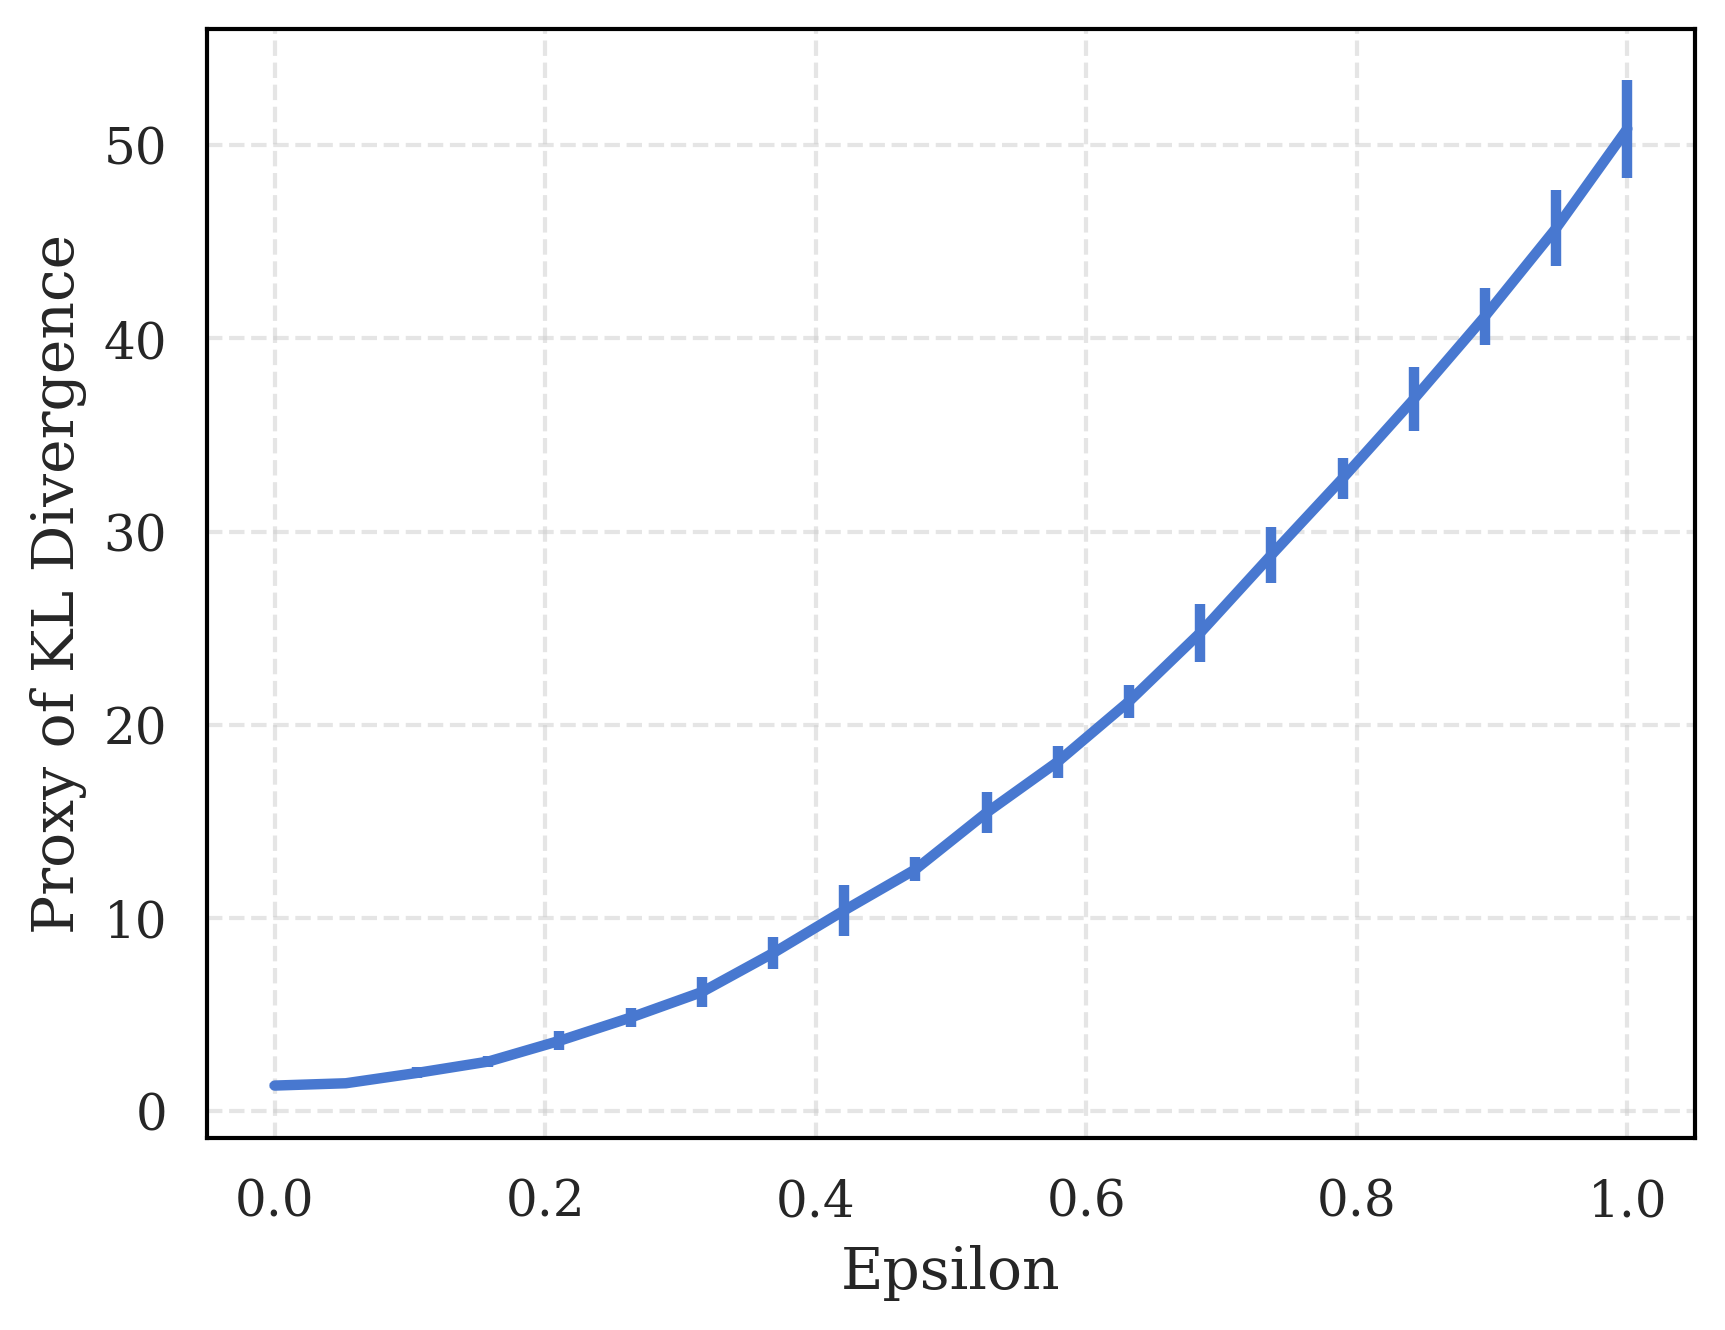

In [24]:
n_jobs = -1

# queremos maximizar E_y[ -\log \pi(y | x', D)] con y \sim p(y | x, D)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    y_samples = model.sample_predictive_distribution(x, num_samples=100)
    val = -torch.mean(torch.log(pi(y_samples, x_adv_distr, model.sample_posterior_distribution(100))))
    return val

kl_alls = []
# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons
    )
    kl_alls.append(kl_values)

# error bars as std
plt.errorbar(epsilons, np.mean(kl_alls, axis=0), yerr=2*np.std(kl_alls, axis=0))
plt.xlabel('Epsilon')
plt.ylabel('Proxy of KL Divergence')

### Case 2b: Same model as case 1

In [37]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [38]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = Adam([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

(array([173., 168., 119., 140., 116.,  89.,  57.,  49.,  36.,  21.,  11.,
          5.,   7.,   2.,   4.,   0.,   2.,   0.,   0.,   1.]),
 array([8.51934962e-03, 1.87226784e+00, 3.73601634e+00, 5.59976483e+00,
        7.46351333e+00, 9.32726182e+00, 1.11910103e+01, 1.30547588e+01,
        1.49185073e+01, 1.67822558e+01, 1.86460043e+01, 2.05097528e+01,
        2.23735013e+01, 2.42372498e+01, 2.61009983e+01, 2.79647468e+01,
        2.98284953e+01, 3.16922437e+01, 3.35559922e+01, 3.54197407e+01,
        3.72834892e+01]),
 <BarContainer object of 20 artists>)

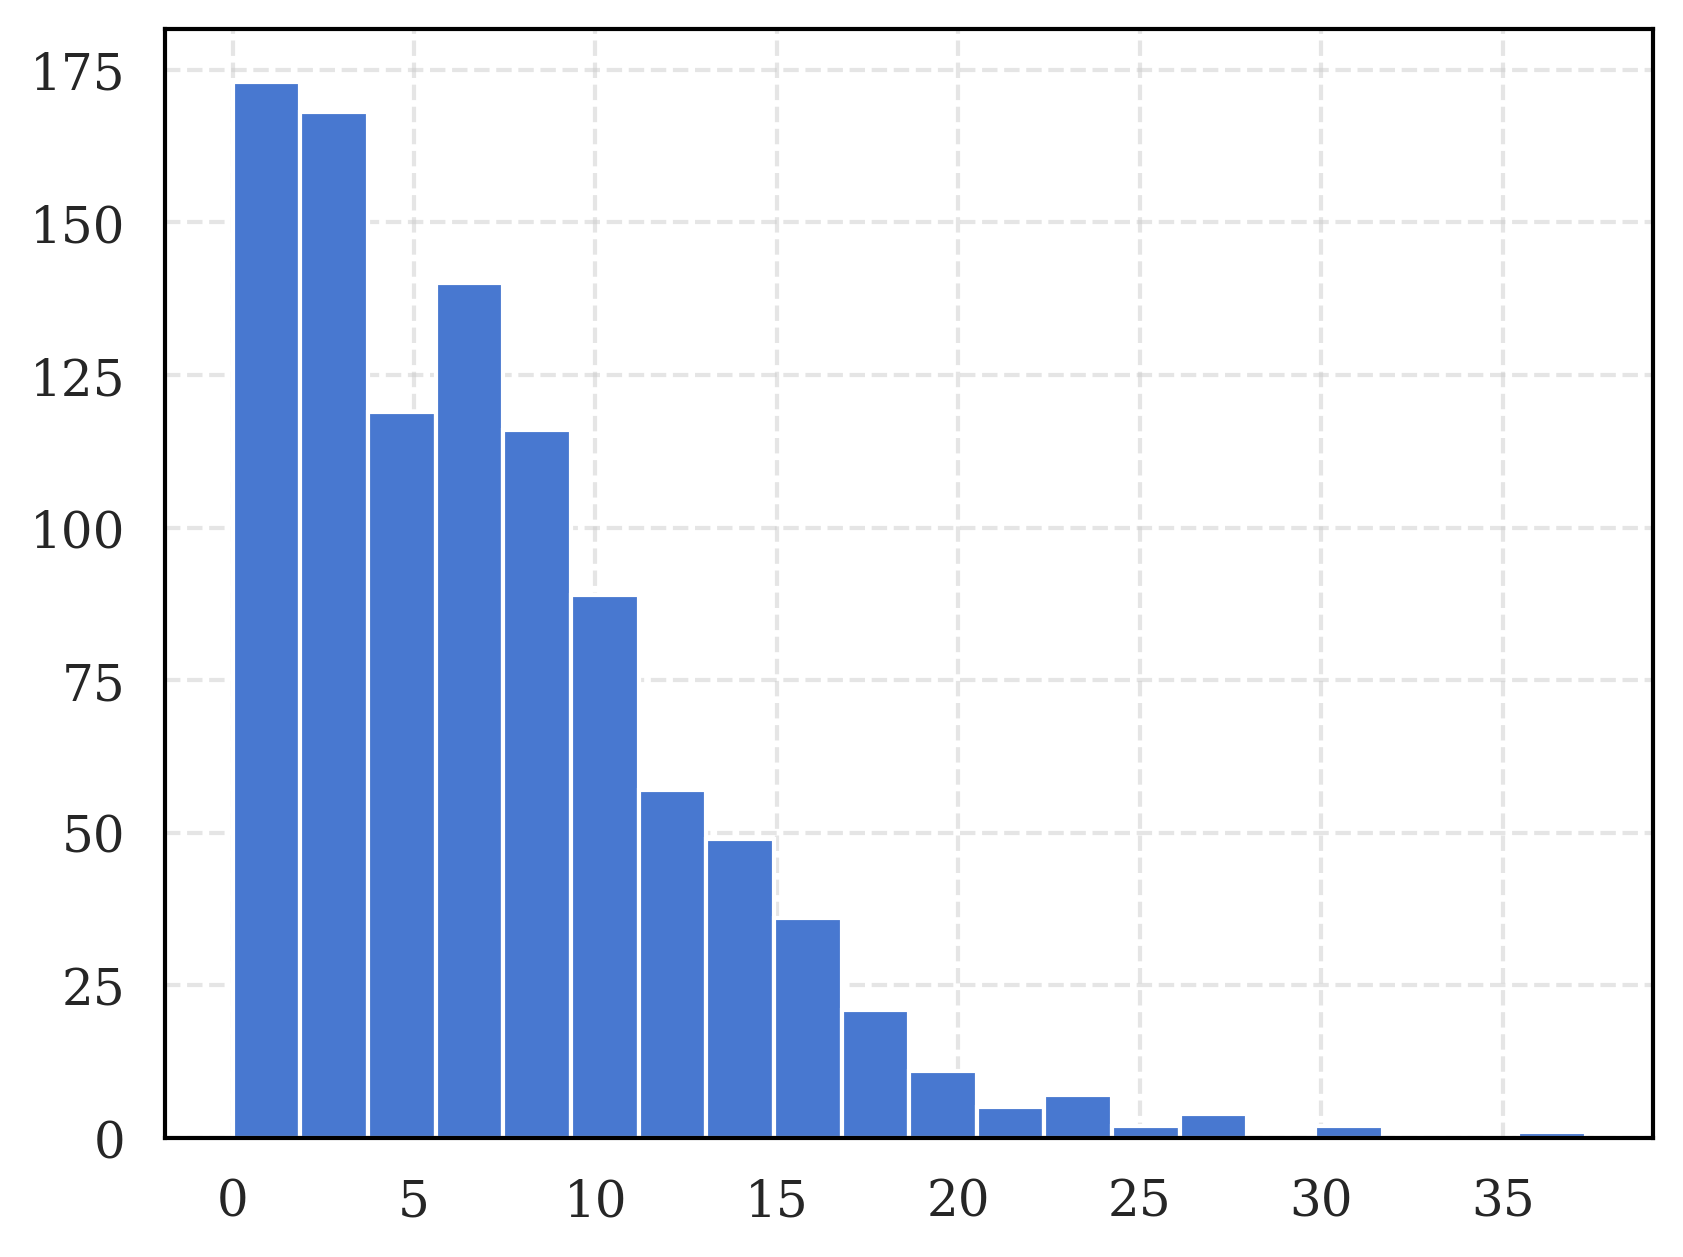

In [27]:
norms = []
for it in range(1000):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    norms.append(torch.norm(real_grad - gradient_estimate).detach().item())
        
plt.hist(norms, bins=20)

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(array([  4.,   4.,  12.,  18.,  38.,  73.,  92., 131., 133., 117., 119.,
        103.,  53.,  50.,  23.,  15.,   8.,   3.,   3.,   1.]),
 array([0.02156361, 0.08355471, 0.14554581, 0.2075369 , 0.269528  ,
        0.3315191 , 0.3935102 , 0.45550129, 0.51749239, 0.57948349,
        0.64147459, 0.70346568, 0.76545678, 0.82744788, 0.88943898,
        0.95143007, 1.01342117, 1.07541227, 1.13740337, 1.19939446,
        1.26138556]),
 <BarContainer object of 20 artists>)

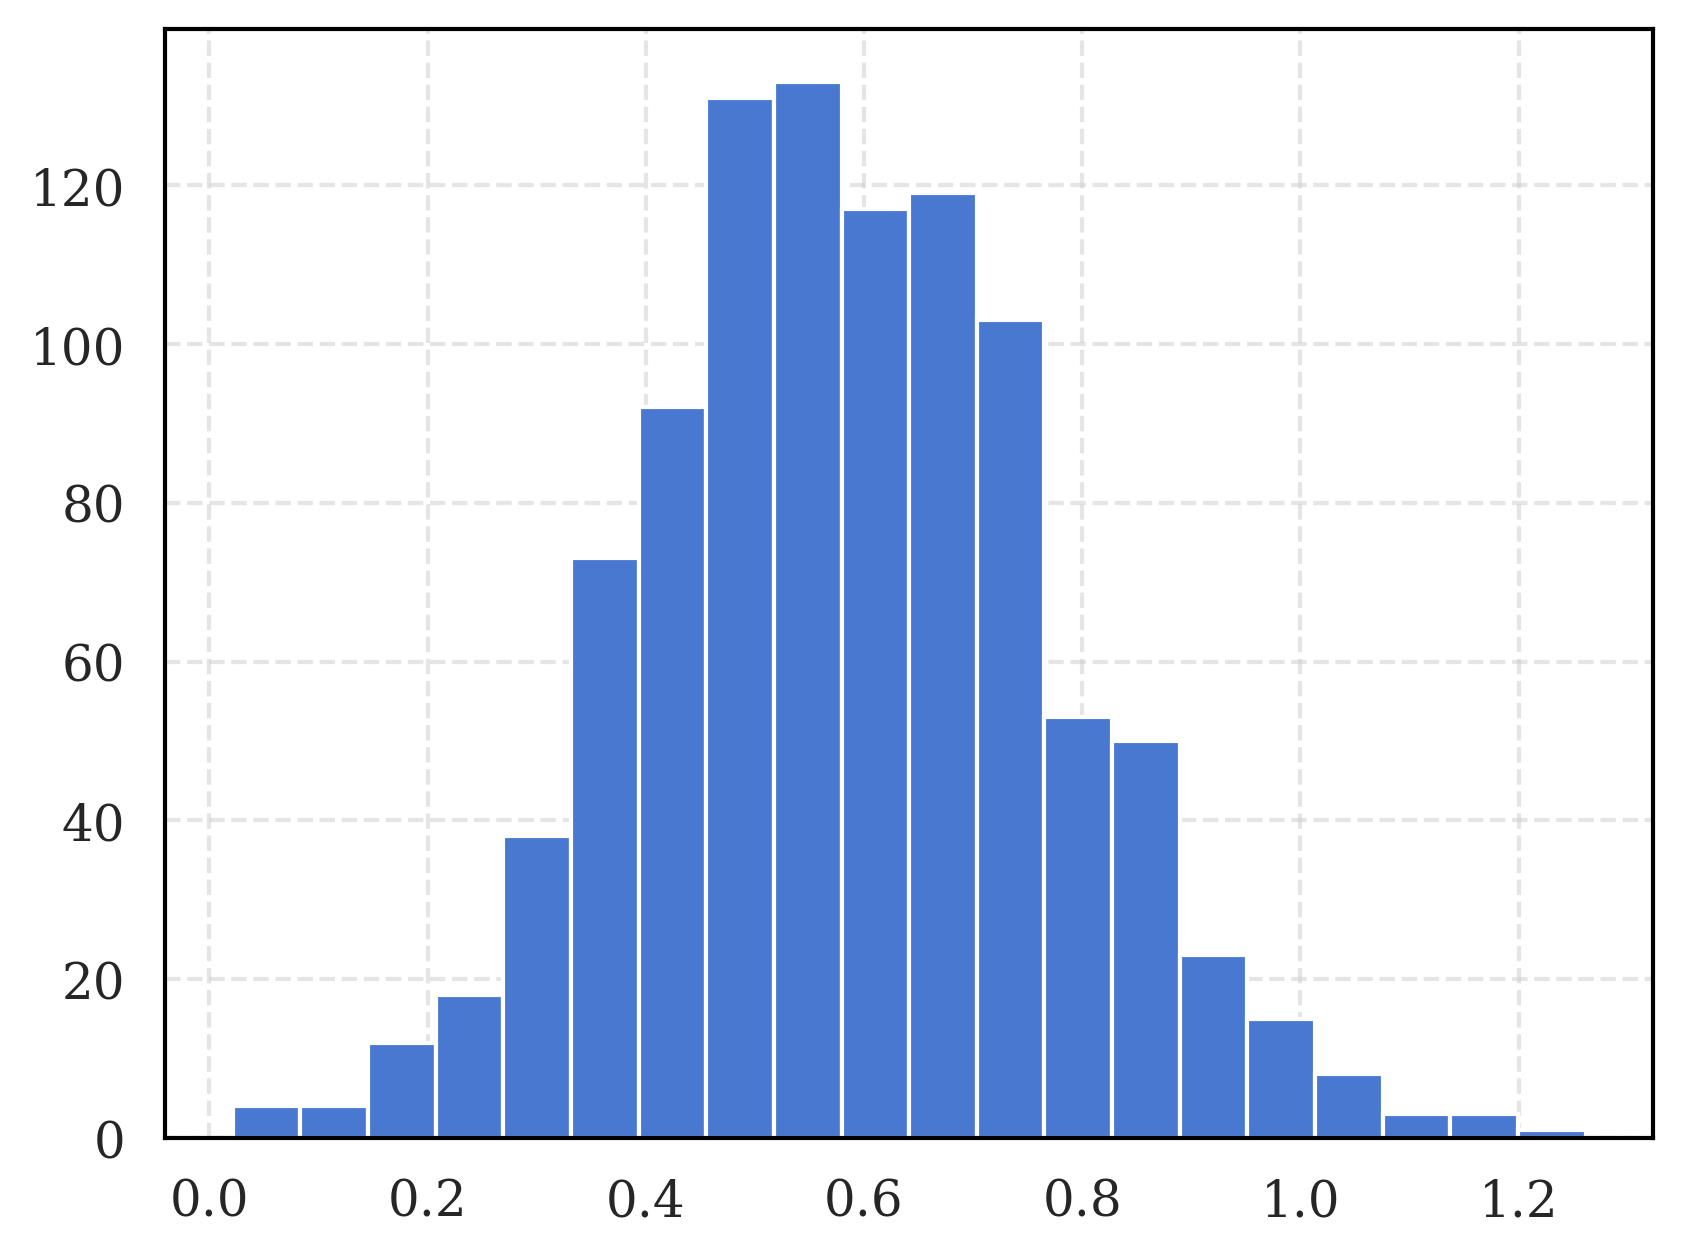

In [39]:
# same as before but estimate the gradient doing the mean of 1000 iterations and doing it in paralell with joblib

def compute_norms(it):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
    for _ in range(100):
        y = model.sample_predictive_distribution(x, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
        gradient_estimate += gradient_estimate
    gradient_estimate /= 101
    return torch.norm(real_grad - gradient_estimate).detach().item()

n_jobs = 66
norms = Parallel(n_jobs=n_jobs)(delayed(compute_norms)(i) for i in range(1000))
plt.hist(norms, bins=20)

In [30]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal( 3 * x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5)

Long gradient estimation time: 4.82763147354126 for iteration 0


Text(0.5, 0, 'y')

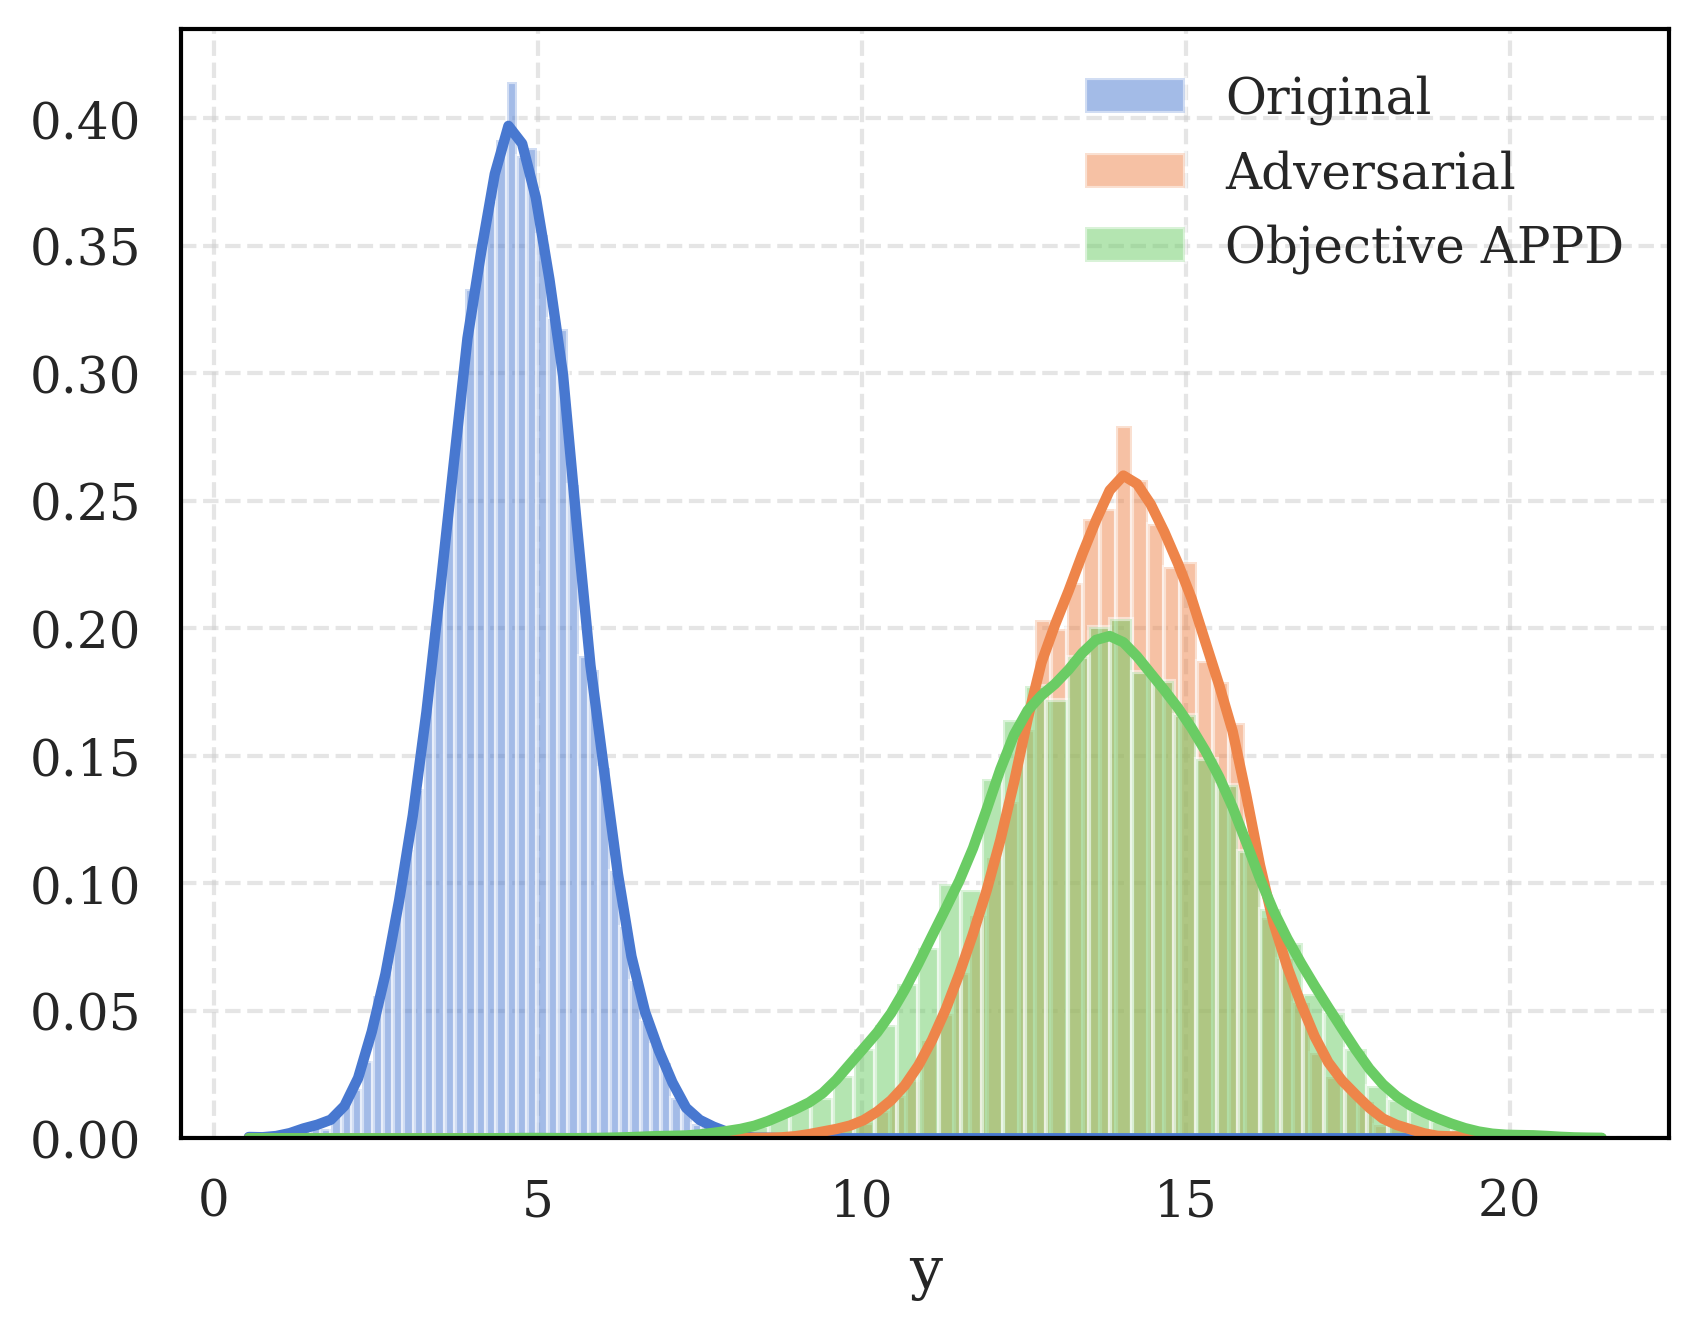

In [31]:
y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()
y_appd_samples = appd.sample((10000,)).numpy()

kde = gaussian_kde(y_samples.T)
kde_adv = gaussian_kde(y_adv_samples.T)
kde_appd = gaussian_kde(y_appd_samples.T)

plt.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)
plt.hist(y_appd_samples, bins=50, alpha=0.5, label='Objective APPD', density=True)

ys = np.linspace(
    min(np.min(y_samples), np.min(y_adv_samples), np.min(y_appd_samples)), 
    max(np.max(y_samples), np.max(y_adv_samples), np.max(y_appd_samples)), 
    100)
# plot with same color and label
plt.plot(ys, kde(ys), color='C0')
plt.plot(ys, kde_adv(ys), color='C1')
plt.plot(ys, kde_appd(ys), color='C2')
plt.legend()
plt.xlabel('y')


In [32]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=0.3)

Early stopping at iteration 13


Text(0.5, 0, 'y')

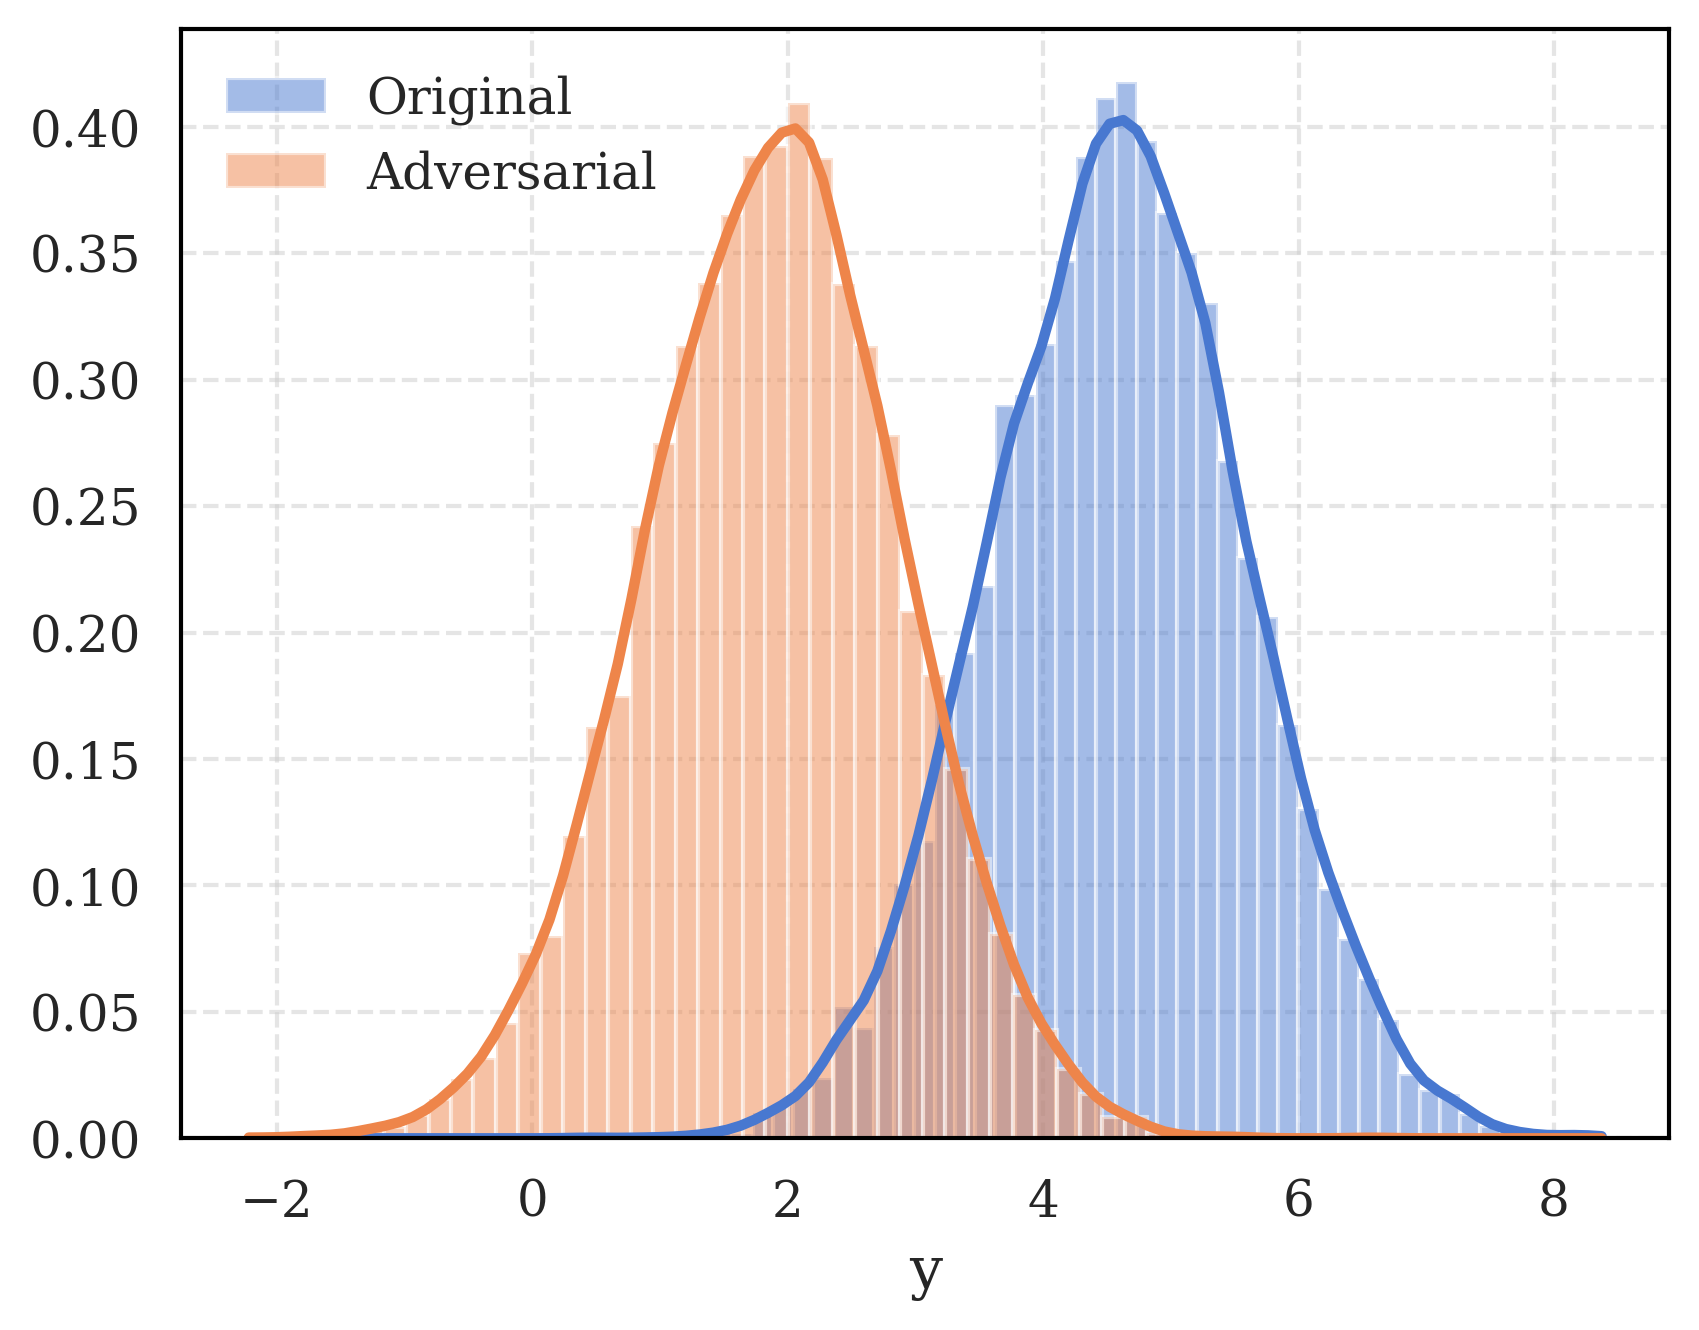

In [33]:
y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()

kde = gaussian_kde(y_samples.T)
kde_adv = gaussian_kde(y_adv_samples.T)

plt.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

ys = np.linspace(
    min(np.min(y_samples), np.min(y_adv_samples)), 
    max(np.max(y_samples), np.max(y_adv_samples)), 
    100)
# plot with same color and label
plt.plot(ys, kde(ys), color='C0')
plt.plot(ys, kde_adv(ys), color='C1')
plt.legend()
plt.xlabel('y')

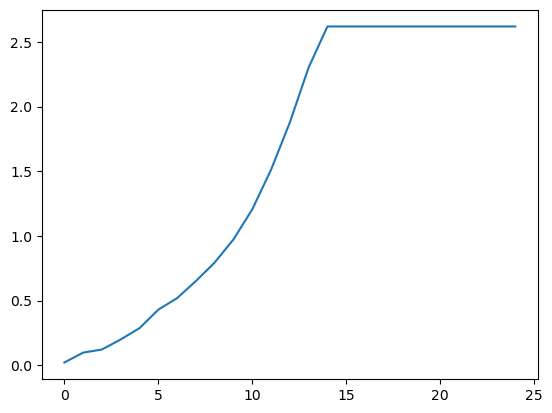

In [26]:
# plot KL evolution
kl_values = [kl_div(model.mu, model.lam, model.sigma2, x, torch.tensor(x_adv, dtype=torch.float32)).item() for x_adv in x_adv_values]

plt.plot(kl_values)

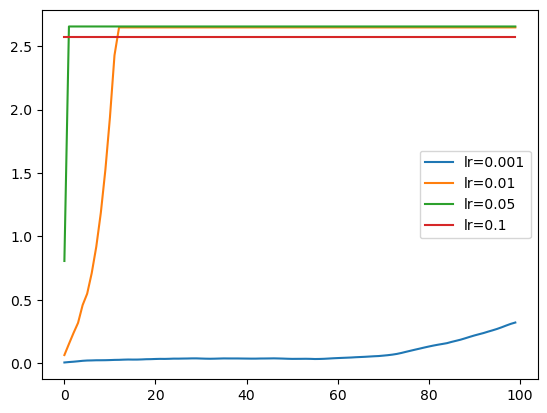

In [27]:
# plot kl evolution for different learning rates with joblib
lrs = [0.001, 0.01, 0.05, 0.1]

n_jobs = -1

def kl_values(lr):
    x = X_test[17,:].copy()
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    x_adv_distr, x_adv_values = mlmc_attack(model, x, lr=lr, epsilon=0.3, early_stopping_patience=100)
    kl_values = [kl_div(model.mu, model.lam, model.sigma2, x, torch.tensor(x_adv, dtype=torch.float32)).item() for x_adv in x_adv_values]
    return kl_values    

kl_values_list = Parallel(n_jobs=n_jobs)(
    delayed(kl_values)(lr) for lr in lrs
)

for kls, lr in zip(kl_values_list, lrs):
    plt.plot(kls, label=f'lr={lr}')
plt.legend()

Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy const

Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16
Early stopping at iteration 17


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 19


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 18
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 19
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 17
Early stopping at iteration 14
Early stopping at iteration 16
Early stopping at iteration 12
Early stopping at iteration 15
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy const

Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 17
Early stopping at iteration 19
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 16
Early stopping at iteration 15
Early stopping at iteration 15
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy const

Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 16
Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 27
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 16
Early stopping at iteration 17


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 17
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 13
Early stopping at iteration 19
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 17
Early stopping at iteration 17


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 22


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 21


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 17
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy const

Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 16
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 16
Early stopping at iteration 15
Early stopping at iteration 19
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 16
Early stopping at iteration 16
Early stopping at iteration 15
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy const

Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16
Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 16
Early stopping at iteration 16
Early stopping at iteration 14
Early stopping at iteration 17
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 19
Early stopping at iteration 16
Early stopping at iteration 22
Early stopping at iteration 18
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 16
Early stopping at iteration 14
Early stopping at iteration 12
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 19
Early stopping at iteration 16
Early stopping at iteration 19


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 16
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy const

Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 19


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 16
Early stopping at iteration 16
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 20
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 17
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 14
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy const

Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 16
Early stopping at iteration 16


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 18


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 19


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 16
Early stopping at iteration 16
Early stopping at iteration 15
Early stopping at iteration 18
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 22
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early st

/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 13
Early stopping at iteration 13


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 15
Early stopping at iteration 15


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 17


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 19
Early stopping at iteration 19


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 19


/tmp/ipykernel_4088304/27420765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 16
Early stopping at iteration 19
Early stopping at iteration 16
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 20
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 21
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 17
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15
Early st

Text(0, 0.5, 'KL Divergence')

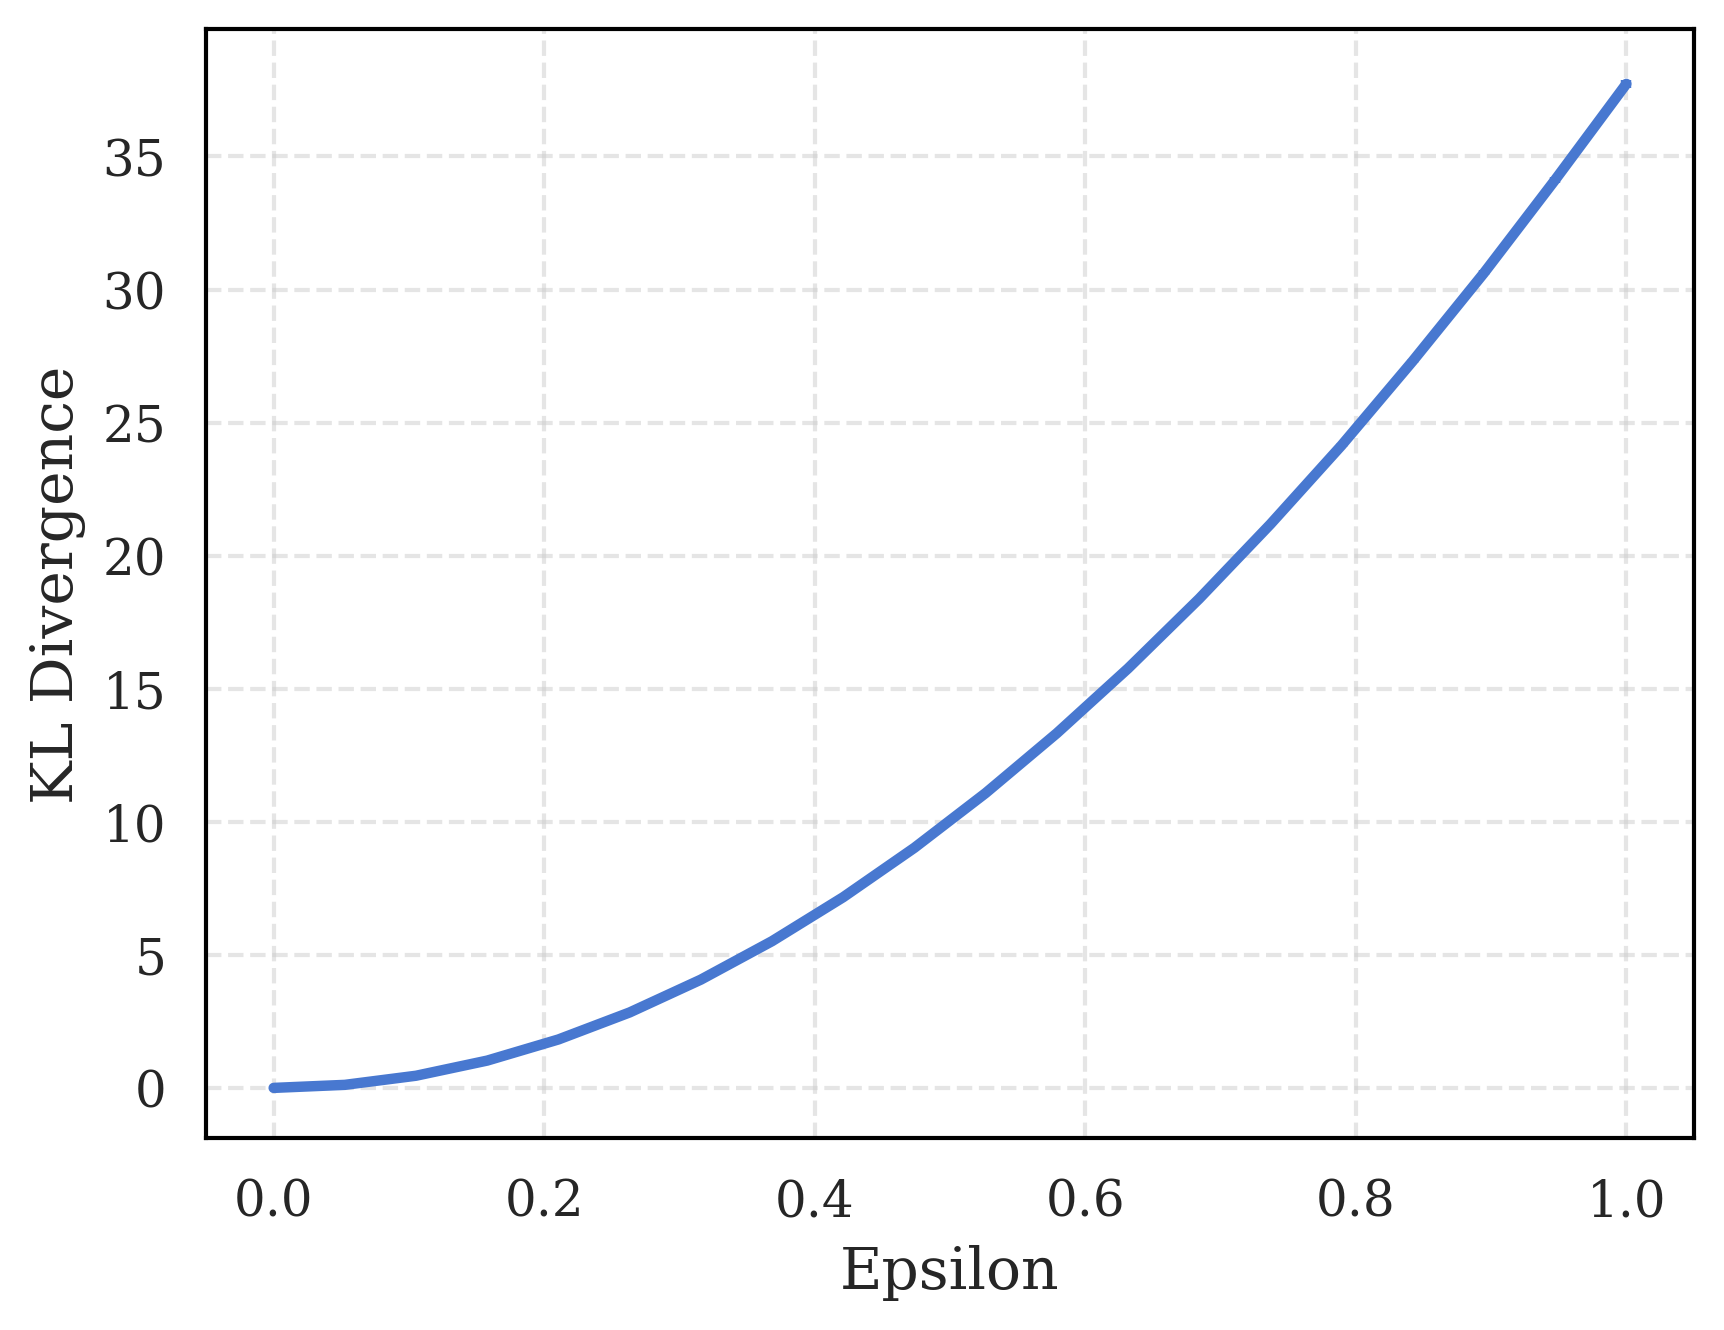

In [34]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    max_kl = 0
    for _ in range(10):
        x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
        kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
        if kl > max_kl:
            max_kl = kl
    return max_kl


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

# error bars as std
plt.errorbar(epsilons, np.mean(kl_alls, axis=0), yerr=2*np.std(kl_alls, axis=0))
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

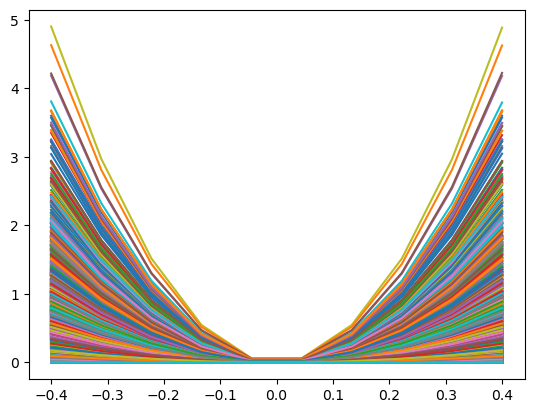

In [29]:
# For random directions (no attack), plot the KL divergence as a function of the strength of the attack
n_directions = 2000
n_values_per_direction = 10
kl_lists = []
eps_max = .4

for _ in range(n_directions):
    direction = torch.randn_like(x)
    direction /= torch.norm(direction, p=2)
    kl_values = []
    for epsilon in np.linspace(-1 * eps_max, 1 * eps_max, n_values_per_direction):
        x_adv = x + epsilon * direction
        kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv).item()
        kl_values.append(kl)
    kl_lists.append(kl_values)

# represent each line in a different color
for kl_values in kl_lists:
    plt.plot(np.linspace(-1 * eps_max, 1 * eps_max, n_values_per_direction), kl_values)


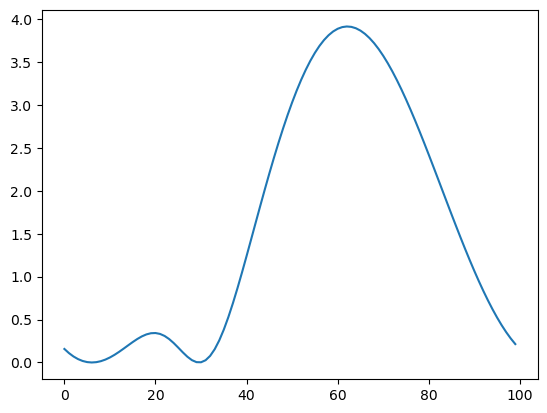

In [36]:
kl_values = []
num_ite = 100

original_point = torch.randn_like(x)
original_point /= torch.norm(original_point, p=2)
original_point = x + eps_max * original_point

direction = torch.randn_like(x)
direction /= torch.norm(direction, p=2)

ortogonal_direction = torch.randn_like(x)
ortogonal_direction /= torch.norm(ortogonal_direction, p=2)
ortogonal_direction = ortogonal_direction - ortogonal_direction.T @ direction * direction
ortogonal_direction /= torch.norm(ortogonal_direction, p=2)

for it in range(num_ite):
    border_point = original_point + direction * np.cos(2 * it * np.pi / num_ite) + ortogonal_direction * np.sin(2 * it * np.pi / num_ite)
    border_point /= torch.norm(border_point, p=2)
    border_point = x + eps_max * border_point

    kl = kl_div(model.mu, model.lam, model.sigma2, x, border_point).item()
    kl_values.append(kl)

plt.plot(kl_values)

### 2c Just backprop of E_y[ -\log \pi(y | x', D)] ? In theory biased

In [35]:
# queremos maximizar E_y[ -\log \pi(y | x', D)] ~ E_y[E_{Gamma|D}[-log \pi(y | x', Gamma)]] con y \sim p(y | x, D)

# Function to calculate kl proxy
def kl_proxy(model, x, x_adv, num_samples=100):
    y_samples = model.sample_predictive_distribution(x, num_samples=num_samples)
    return -torch.mean(torch.log(pi(y_samples, x_adv, model.sample_posterior_distribution(num_samples))))

def proxy_maximization(model, x, lr=0.01, n_iter=100, epsilon=.3, num_samples=100):
    x_adv_values = []
    proxy_values = []
    
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        proxy = - kl_proxy(model, x, x_adv, num_samples=num_samples)  # maximum disruption problem
        proxy.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        proxy_values.append(-proxy.detach().item())

    return x_adv.detach(), x_adv_values, proxy_values 

In [66]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [86]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_proxy, x_adv_values, proxy_values = proxy_maximization(model, x, epsilon=0.3, num_samples=100)

Text(0.5, 0, 'y')

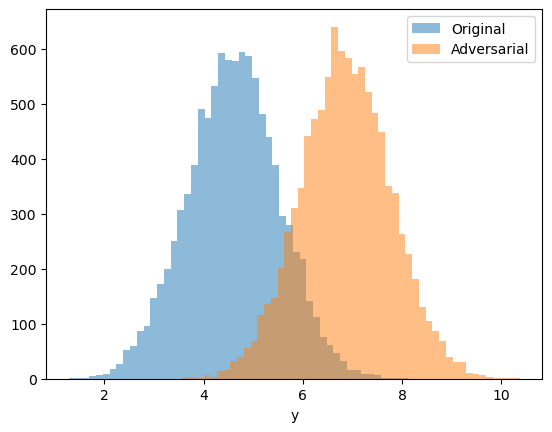

In [87]:
y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
y_adv_samples = model.sample_predictive_distribution(x_adv_proxy, num_samples=10000).numpy()

kde = gaussian_kde(y_samples.T)
kde_adv = gaussian_kde(y_adv_samples.T)

plt.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

ys = np.linspace(
    min(np.min(y_samples), np.min(y_adv_samples)), 
    max(np.max(y_samples), np.max(y_adv_samples)), 
    100)
# plot with same color and label
plt.plot(ys, kde(ys), color='C0')
plt.plot(ys, kde_adv(ys), color='C1')
plt.legend()
plt.xlabel('y')

#### Veamos que el gradiente esta sesgado

In [30]:
def proxy_gradient(model, x, num_samples=100):
    optimizer = Adam([x_adv], lr=0.0)
    x_adv.requires_grad = True
    optimizer.zero_grad()
    proxy = - kl_proxy(model, x, x_adv, num_samples=num_samples)  # maximum disruption problem
    proxy.backward()
    grad = x_adv.grad.clone().detach()
    x_adv.grad.zero_()

    return grad

In [31]:
X, y = get_toy_data()

In [32]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [33]:
# Model for which we know the true gradient
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [54]:
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = Adam([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

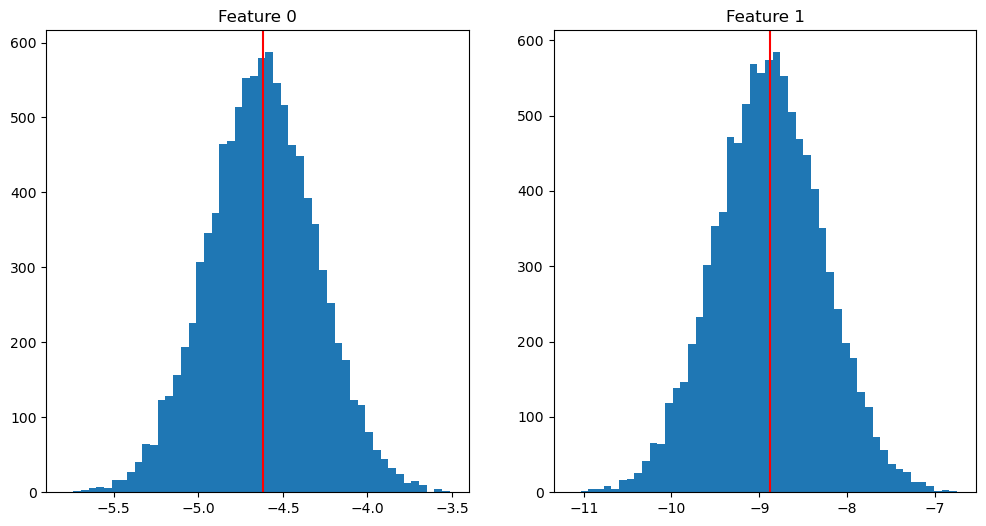

In [56]:
grads = []
for it in range(10000):
    grad = proxy_gradient(model, x, num_samples=1000)
    grads.append(grad)

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=50)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_title(f'Feature {i}')